# Анализ бизнес-показателей

## Описание проекта

Анализируем данные сайта с билетами на различные мероприятия.

**Цель**: помочь маркетологам оптимизировать маркетинговые затраты.

Для этого нужно **изучить**:
- Как люди пользуются продуктом,
- Когда они начинают покупать,
- Сколько денег приносит каждый клиент,
- Когда клиент окупается.


**Данные**:

1. Таблица `visits` (лог сервера с информацией о посещениях сайта):
   - `Uid` — уникальный идентификатор пользователя,
   - `Device` — категория устройства пользователя,
   - `Start Ts` — дата и время начала сессии,
   - `End Ts` — дата и время окончания сессии,
   - `Source Id` — идентификатор рекламного источника, из которого пришел пользователь;
   
   
2. Таблица `orders` (информация о заказах):
   - `Uid` — уникальный id пользователя, который сделал заказ,
   - `Buy Ts` — дата и время заказа,
   - `Revenue` — выручка Яндекс.Афиши с этого заказа;


3. Таблица `costs` (информация о затратах на маркетинг):
   - `source_id` — идентификатор рекламного источника,
   - `dt` — дата,
   - `costs` — затраты на этот рекламный источник в этот день.

Период данных: июнь 2017 – конец мая 2018.

## <a id='content'>Содержание проекта</a>

1. [Предварительная настройка и подготовка](#setup).


2. [Загрузка и подготовка данных](#prepare).


3. Построение отчетов и расчет метрик:

   - [Метрики продукта](#metrics_product):
     - Сколько людей пользуются в день, неделю, месяц (средние DAU, WAU, MAU за весь период; DAU, WAU, MAU в разрезах по источникам и устройствам; оценка вовлеченности (sticky factor));
     - Сколько сессий в день (среднее количество сессий в день за весь период / в динамике по месяцам; среднее количество сессий в день на одного пользователя за весь период / в динамике по месяцам);
     - Сколько длится одна сессия (ASL);
     - Retention Rate.
		
        
   - [Показатели по продажам](#metrics_sales):
     - Когда люди начинают покупать;
     - Сколько раз покупают за период (среднее количество покупок в месяц по всем покупателям, когортный анализ, среднее количество покупок в месяц в разрезах по источникам привлечения и устройствам пользователей);
     - Средний чек (за весь период по всем покупателям, динамика по месяцам, в разрезах по источникам привлечения и устройствам пользователей);
     - LTV;
     
     
   - [Маркетинговые показатели](#metrics_marketing):
     - Когортный анализ LTV и ROI;
     - Сколько денег потратили (всего / на каждый источник / по времени);
     - CAC;
     - ROI;


4. [Выводы и рекомендации](#results).

---

## <a id='setup'>Предварительная настройка и подготовка</a>

1. Импорт библиотек:

In [1]:
import pandas as pd
import numpy as np
import math as mt

import matplotlib.pyplot as plt
import seaborn as sns

2. Настройки:

In [2]:
# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

# Настройка отображения вещественных чисел, чтобы было максимум 2 знака после запятой
pd.options.display.float_format = '{: .2f}'.format

# Увеличение количества отображаемых столбцов, чтобы при росте количества колонок видеть их все
pd.set_option('display.max_columns', 500)

3. Параметры для графиков `matplotlib`:

In [3]:
large = 20; medium = 14; small = 12
params = {'axes.titlesize': large,
          'axes.labelsize': medium,
          'legend.fontsize': medium,
          'figure.titlesize': large,
          'figure.figsize': (8, 5),
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'axes.grid': True,
          'legend.loc': 'upper left',
          'axes.titlepad': 25.0 # отступ названия графика
         }
plt.rcParams.update(params)

# plt.rcParams.keys() # список параметров 

4. Функция для построения тепловой карты. Аргументы функции:
   - `df` – датафрейм,
   - `title` – название графика,
   - `xlabel` – подпись горизонтальной оси (необязательный параметр),
   - `ylabel` – подпись вертикальной оси (необязательный параметр),
   - `fmt` – формат вывода значений (необязательный параметр),
   - `figsize` – размер фигуры (необязательный параметр).

In [4]:
def make_heatmap(
    df, 
    title, 
    xlabel = u'Время жизни когорты', 
    ylabel = u'Когорты',
    fmt = '.2g',
    figsize = (15, 10)):
    
    sns.set(style='white')
    plt.figure(figsize=figsize)
    plt.title(title)
    
    # если по оси y даты (когорты по времени), то выводим только год и месяц
    if '00:00' in str(df.index[0]):
        sns.heatmap(df, annot=True, linewidths=1, linecolor='gray', fmt=fmt, cmap='coolwarm', \
                   yticklabels = df.index.strftime('%Y-%m'))
    else:
        sns.heatmap(df, annot=True, linewidths=1, linecolor='gray', fmt=fmt, cmap='coolwarm') 
    
    plt.yticks(rotation=0)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    return

<div align='right'><a href='#content'>↑ В начало проекта ↑</a></div>

---

## <a id='prepare'>Шаг 1. Загрузка и подготовка данных</a>

**Задание**: загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный.

1. Так как таблиц у нас три, напишем функцию `import_data`, которая:

   - Будет принимать на вход название файла с таблицей (только имя без расширения);
   - Ввыводить первые/последние/случайны строки из таблицы, информацию о ней (`info()`) и числовое описание данных;
   - Возвращать прочитанный из файла датафрейм, чтобы его можно было сохранить в переменную.

In [5]:
def import_data(data_name):   
    data = pd.read_csv('/datasets/{}.csv'.format(data_name))
    
    print('\033[1m' + 'Первые строки:' + '\033[0m')
    display(data.head())
    
    print()
    print('\033[1m' + 'Последние строки:' + '\033[0m')
    display(data.tail())
    
    print()
    print('\033[1m' + 'Случайно выбранные строки (sample):' + '\033[0m')
    display(data.sample(5))
    
    
    print()
    print('\033[1m' + 'Информация о таблице:' + '\033[0m')
    print()
    display(data.info())
    
    print('\033[1m' + '\nЧисловое описание данных:' + '\033[0m')
    display(data.describe())
    
    return data

2. Прочитаем файлы с данными в соответствующие переменные:
   - `visits`— лог сервера с информацией о посещениях сайта;
   - `orders` — информация о заказах;
   - `costs` - информация о затратах на маркетинг.

In [6]:
visits = import_data('visits_log')

Первые строки:


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168



Последние строки:


,Device,End Ts,Source Id,Start Ts,Uid
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485
359399,touch,2017-09-10 13:13:19,2,2017-09-10 13:13:00,18396128934054549559



Случайно выбранные строки (sample):


,Device,End Ts,Source Id,Start Ts,Uid
175064,desktop,2018-01-10 21:04:00,4,2018-01-10 20:45:00,3584088616895148591
183482,desktop,2018-02-17 12:19:00,3,2018-02-17 12:17:00,8788990805578025631
153766,desktop,2017-10-13 01:27:00,5,2017-10-13 01:24:00,14381809965214273455
64310,desktop,2017-09-11 09:42:00,3,2017-09-11 09:38:00,15906902296438097189
353444,touch,2017-06-08 16:36:00,5,2017-06-08 15:32:00,5439940783307999993



Информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None


Числовое описание данных:


,Source Id,Uid
count,359400.00,359400.00
mean,3.75,9202556994354921472.00
std,1.92,5298432824659611648.00
min,1.00,11863502262781.00
25%,3.00,4613406732167550976.00
50%,4.00,9227412908740601856.00
75%,5.00,13728237011236173824.00
max,10.00,18446676030785673216.00


In [7]:
orders = import_data('orders_log')

Первые строки:


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450



Последние строки:


,Buy Ts,Revenue,Uid
50410,2018-05-31 23:50:00,4.64,12296626599487328624
50411,2018-05-31 23:50:00,5.80,11369640365507475976
50412,2018-05-31 23:54:00,0.30,1786462140797698849
50413,2018-05-31 23:56:00,3.67,3993697860786194247
50414,2018-06-01 00:02:00,3.42,83872787173869366



Случайно выбранные строки (sample):


,Buy Ts,Revenue,Uid
30461,2018-01-22 12:53:00,6.42,13614796322306996250
44206,2018-04-15 20:25:00,4.28,2372603640946287896
37577,2018-03-01 16:48:00,5.50,11241372054346195284
11750,2017-10-09 12:23:00,4.28,9861636867831104411
49994,2018-05-31 10:59:00,5.50,3696354975603984536



Информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None


Числовое описание данных:


,Revenue,Uid
count,50415.00,50415.00
mean,5.00,9098160634289729536.00
std,21.82,5285741550834715648.00
min,0.00,313578113262317.00
25%,1.22,4533566627250599936.00
50%,2.50,9102273602618561536.00
75%,4.89,13682901980465401856.00
max,2633.28,18446167067214817280.00


In [8]:
costs = import_data('costs')

Первые строки:


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08



Последние строки:


,source_id,dt,costs
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15
2541,10,2018-05-31,17.60



Случайно выбранные строки (sample):


,source_id,dt,costs
770,3,2017-07-15,306.19
1299,4,2017-12-28,89.49
1311,4,2018-01-09,66.62
1204,4,2017-09-24,170.74
127,1,2017-10-06,76.57



Информация о таблице:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None


Числовое описание данных:


,source_id,costs
count,2542.00,2542.00
mean,4.86,129.48
std,3.18,156.30
min,1.00,0.54
25%,2.00,21.95
50%,4.00,77.30
75%,9.00,170.06
max,10.00,1788.28


3. Переименуем столбцы в таблицах `visits` и `orders`: приведем названия к нижнему регистру и заменим пробелы на символ подстроки (`_`):

In [9]:
for df in (visits, orders):
    # приводим к нижнему регистру
    df.columns = df.columns.str.lower()
    # заменяем пробелы на _
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    display(df.head())

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


4. Преобразуем типы данных в столбцах с датами:

В таблицах `visits` и `orders` названия столбцов с датами заканчиваются на «_ts», поэтому можем обработать их в цикле:

In [10]:
for df in (visits, orders):
    for col in df.columns:
        if '_ts' in col:
            df[col] = pd.to_datetime(df[col], format='%Y-%m-%d %H:%M:%S')
            print('Тип данных в столбцe {}: {}'.format(col, df[col].dtypes))

Тип данных в столбцe end_ts: datetime64[ns]
Тип данных в столбцe start_ts: datetime64[ns]
Тип данных в столбцe buy_ts: datetime64[ns]


В таблице `costs` тоже есть столбец с датой – `dt` – преобразуем его тип данных отдельно, так как название столбца не вписывается в логику предыдущего цикла:

In [11]:
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')
print('Тип данных в столбцe dt таблицы costs: {}'.format(costs['dt'].dtypes))

Тип данных в столбцe dt таблицы costs: datetime64[ns]


### Промежуточные выводы

На этом шаге мы:

1. Загрузили данные о визитах, заказах и расходах в переменные.
2. Переименовали столбцы в таблицах: привели названия к нижнему регистру и заменили пробелы на символ подчеркивания (`_`).
3. Преобразовали типы данных в столбцах с датами.

<div align='right'><a href='#content'>↑ В начало проекта ↑</a></div>

---

## Шаг 2. Построение отчетов и расчет метрик

### <a id='metrics_product'>2.1. Метрики продукта</a>

#### 1. Сколько людей пользуются в день, неделю, месяц

**а) Подготовка**

Данные по использованию продукта хранятся в таблице `visits`. Чтобы посчитать среднее DAU, WAU и MAU, выделим в отдельные столбцы год, месяц, неделю и полную дату без времени из столбца `start_ts` (дата и время начала сессии):

In [12]:
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date

visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


**б) Средние DAU, WAU, MAU за весь период**

Посчитаем среднюю аудиторию в день (DAU), неделю (WAU) и месяц (MAU) за весь период. Для этого сгруппируем данные по уникальным пользователям за соответствующий период и найдём среднее за всё время:

In [13]:
# задаем список метрик и столбцов, по которым нужно группировать таблицу
metrics_set = {
    'dau_mean':['session_date'],
    'wau_mean':['session_year', 'session_week'],
    'mau_mean':['session_year', 'session_month']
}

# в metrics_val будем записывать значения 
metrics_val = {}

# перебираем метрики в цикле
for metric in metrics_set.keys():
    metrics_val[metric] = int(round(visits.groupby(metrics_set[metric])['uid'].nunique().mean()))
    print('{} = {} уникальных пользователей'.format(metric, metrics_val[metric]))

dau_mean = 908 уникальных пользователей
wau_mean = 5716 уникальных пользователей
mau_mean = 23228 уникальных пользователей


Посмотрим на динамику DAU, WAU и MAU:

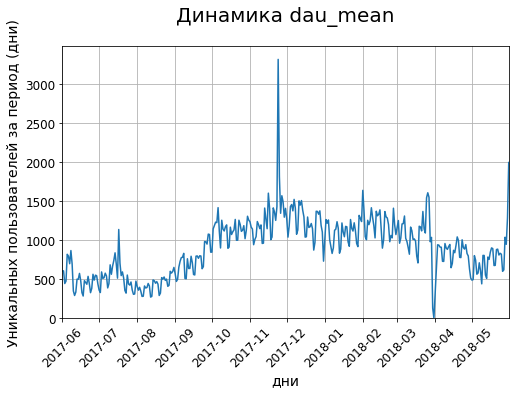

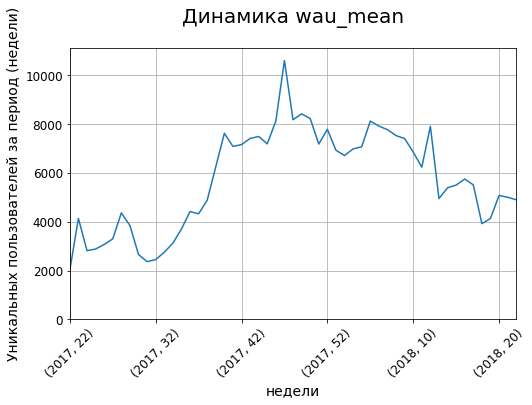

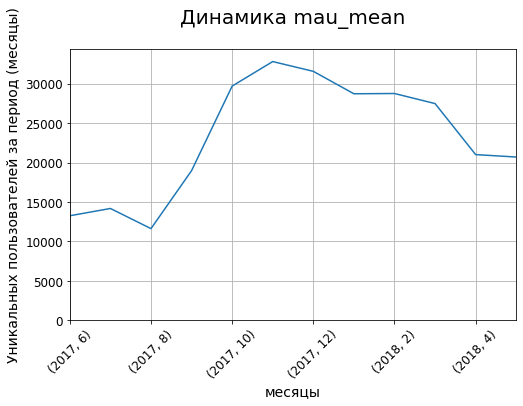

In [14]:
xlabels = {
    'dau_mean':u'дни',
    'wau_mean':u'недели',
    'mau_mean':u'месяцы'
}

for metric in metrics_set.keys():
    nunique_uid = visits.groupby(metrics_set[metric])['uid'].nunique()
    
    nunique_uid.plot(grid=True)
    
    # установим корректные границы вертикальной оси = от нуля до (max + 5% от max)
    plt.ylim(0, nunique_uid.max() + (nunique_uid.max()*5/100).round())
    
    plt.title(u'Динамика {}'.format(metric))
    plt.xlabel(xlabels[metric])
    plt.ylabel(u'Уникальных пользователей за период ({})'.format(xlabels[metric]))
    plt.xticks(rotation=45)
    plt.show()

Дополнительно посмотрим на пиковые значения в DAU:

In [15]:
dau = visits.groupby(['session_date'])['uid'].nunique().reset_index()

print('Минимальный DAU:')
display(dau[dau['uid'] == dau['uid'].min()])
print('Максимальный DAU:')
display(dau[dau['uid'] == dau['uid'].max()])

Минимальный DAU:


,session_date,uid
303,2018-03-31,1


Максимальный DAU:


,session_date,uid
176,2017-11-24,3319


**в) DAU, WAU, MAU в разрезах по источникам и устройствам**

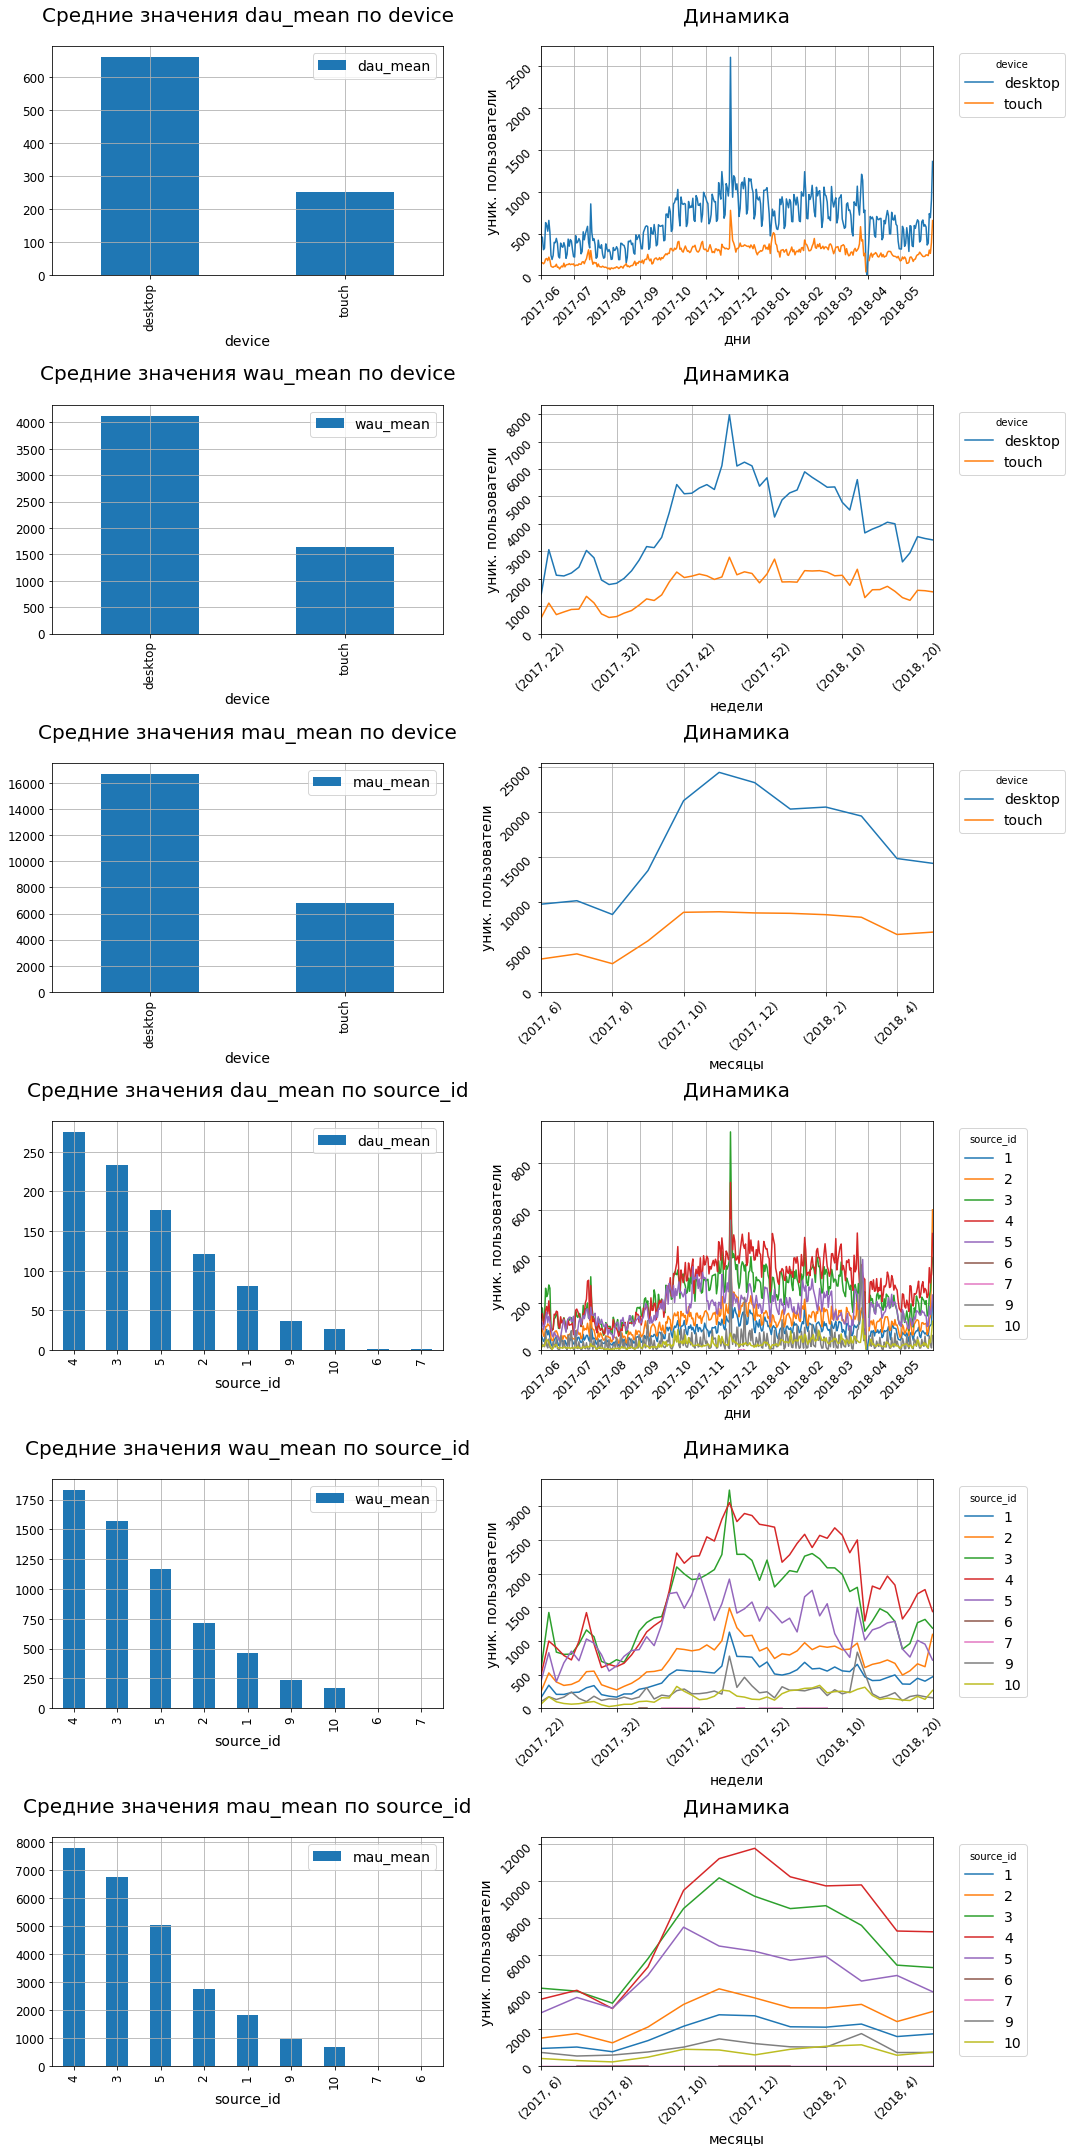

In [16]:
plt.subplots(figsize=(15,30)) # сетка графиков
i = 1 # счетчик графиков в сетке

for report_slice in ['device', 'source_id']:
      
    for metric in metrics_set.keys():
        
        # создаем список параметров для группировки
        group_attrs = [report_slice]        
        for value in metrics_set[metric]:
            group_attrs.append(value)
        
        time_group = visits.groupby(group_attrs).agg({'uid':'nunique'})        
        slice_group = (time_group
                       .groupby([report_slice])
                       .agg({'uid':'mean'})
                       .rename(columns={'uid':metric})
                       .round().astype('int')
                       .sort_values(by=metric, ascending=False))

        slice_group.plot(kind='bar', title='Средние значения {} по {}'.format(metric, report_slice), 
                         ax=plt.subplot(6,2,i))
        i+=1     

        # динамика по месяцам        
        nunique_uid = visits.pivot_table(index=metrics_set[metric], columns=report_slice, \
                                         values='uid', aggfunc='nunique')
                       
        
        nunique_uid.plot(grid=True, ax=plt.subplot(6,2,i))
        i+=1
        
        plt.ylim(bottom=0)
        plt.title(u'Динамика')
        plt.xlabel(xlabels[metric])
        plt.ylabel(u'уник. пользователи')
        plt.legend(bbox_to_anchor=(1.05, 1), title=report_slice)
        plt.yticks(rotation=45)
        plt.xticks(rotation=45)
        plt.tight_layout() # чтобы названия графиков и осей не наезжали друг на друга

plt.show()    

**г) Оценка вовлеченности (sticky factor)**

Среднее значение sticky factor за весь период (чем выше, тем регулярнее пользователи заходят в продукт в течение недели / месяца, а значит, тем вовлеченнее и лояльнее к продукту):

In [17]:
for sf in ['sf_wau', 'sf_mau']:
    # sf.split(sep='_')[1] - разбиваем название sf по разделителю '_' и берем второй элемент
    metrics_val[sf] = int(round(metrics_val['dau_mean'] / metrics_val[sf.split(sep='_')[1] + '_mean'] * 100))
    
    print('{} = {}%'.format(sf, metrics_val[sf]))

sf_wau = 16%
sf_mau = 4%


Посмотрим динамику `sticky factor` (возьмем для примера соотношение `DAU / MAU`). Для этого по каждому дню:
- Посчитаем DAU;
- Вычислим месяц, к которому относится день;
- Посчитаем MAU;
- Поделим DAU каждого дня на MAU месяца, к которому относится день.

In [18]:
# считаем DAU для каждого дня + записываем год и номер месяца для дальнейших расчетов
dau = (visits
                 .groupby(['session_date'])
                 .agg({'session_year':'first', 'session_month':'first', 'uid':'nunique'})
                 .reset_index()
                 .rename(columns={'uid':'dau'})
                )
dau.sample(10)

,session_date,session_year,session_month,dau
266,2018-02-22,2018,2,1200
135,2017-10-14,2017,10,897
235,2018-01-22,2018,1,1266
217,2018-01-04,2018,1,1260
115,2017-09-24,2017,9,662
273,2018-03-01,2018,3,1166
184,2017-12-02,2017,12,1040
152,2017-10-31,2017,10,1259
89,2017-08-29,2017,8,579
190,2017-12-08,2017,12,1411


In [19]:
# считаем MAU для каждого месяца
mau_per_month = (visits
                 .groupby(['session_year', 'session_month'])['uid'].nunique()
                 .reset_index()
                 .rename(columns={'uid':'mau'})
                )
mau_per_month

,session_year,session_month,mau
0,2017,6,13259
1,2017,7,14183
2,2017,8,11631
3,2017,9,18975
4,2017,10,29692
5,2017,11,32797
6,2017,12,31557
7,2018,1,28716
8,2018,2,28749
9,2018,3,27473


In [20]:
# присоединяем MAU к таблице с DAU
dau = dau.merge(mau_per_month, on=['session_year', 'session_month'], how='left')
dau.sample(10)

,session_date,session_year,session_month,dau,mau
334,2018-05-02,2018,5,496,20701
23,2017-06-24,2017,6,328,13259
81,2017-08-21,2017,8,521,11631
257,2018-02-13,2018,2,1314,28749
61,2017-08-01,2017,8,410,11631
310,2018-04-08,2018,4,729,21008
330,2018-04-28,2018,4,799,21008
132,2017-10-11,2017,10,1119,29692
288,2018-03-16,2018,3,992,27473
25,2017-06-26,2017,6,564,13259


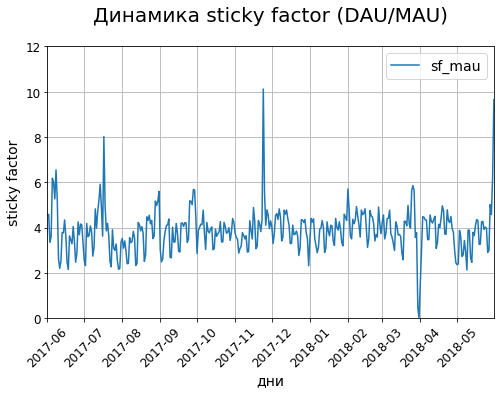

In [21]:
# считаем sticky factor
dau['sf_mau'] = dau['dau'] / dau['mau'] * 100

dau.plot(x='session_date', y='sf_mau', grid=True)
plt.title('Динамика sticky factor (DAU/MAU)')
plt.xlabel('дни')
plt.ylabel('sticky factor')
plt.ylim(0, 12)
plt.xticks(rotation=45)
plt.show()

Проверим среднее значение:

In [22]:
dau['sf_mau'].mean()

3.890664689794207

In [23]:
metrics_val['sf_mau']

4

#### 2. Сколько сессий в день

**а) Среднее количество сессий в день за весь период**

In [24]:
print('Среднее количество сессиий в день: {}'.format(visits
                                                     .groupby(['session_date']).agg({'start_ts':'count'})
                                                     .mean().round().astype('int')['start_ts']))

Среднее количество сессиий в день: 987


**б) Среднее количество сессий в день в динамике по месяцам**

In [25]:
sessions_per_days = visits.groupby(['session_year', 'session_month', 'session_date']).agg({'start_ts':'count'})
sessions_per_days.head()

start_ts
session_year session_month session_date          
2017         6             2017-06-01         664
                           2017-06-02         658
                           2017-06-03         477
                           2017-06-04         510
                           2017-06-05         893

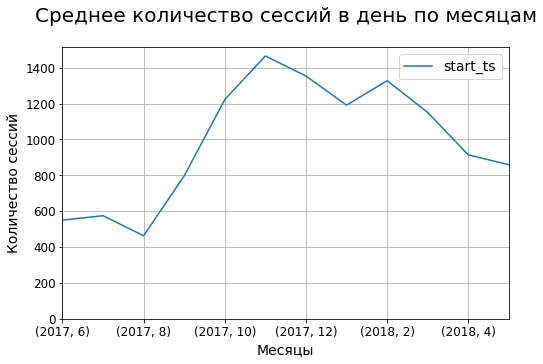

In [26]:
sessions_per_month = sessions_per_days.groupby(['session_year', 'session_month']).agg({'start_ts':'mean'})
sessions_per_month.plot(grid=True)

plt.title('Среднее количество сессий в день по месяцам')
plt.xlabel('Месяцы')
plt.ylabel('Количество сессий')
plt.ylim(bottom=0)
plt.show()

**в) Среднее количество сессий в день на одного пользователя за весь период**

In [27]:
sessions_per_user = (
    visits
    .groupby(['session_date'])
    # запишем и полную дату-время, чтобы вытащить оттуда месяц и посмотреть динамику по месяцам
    .agg({'uid': ['count', 'nunique'], 'start_ts':'first'})
)

# переименуем столбцы
sessions_per_user.columns = ['n_sessions', 'n_users', 'datetime']
sessions_per_user['month'] = sessions_per_user['datetime'].astype('datetime64[M]')

# количество сессий на одного пользователя в день
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']

sessions_per_user.head()

,n_sessions,n_users,datetime,month,sessions_per_user
session_date,,,,,
2017-06-01,664,605,2017-06-01 08:22:00,2017-06-01,1.10
2017-06-02,658,608,2017-06-02 11:27:00,2017-06-01,1.08
2017-06-03,477,445,2017-06-03 08:40:00,2017-06-01,1.07
2017-06-04,510,476,2017-06-04 03:11:00,2017-06-01,1.07
2017-06-05,893,820,2017-06-05 14:01:00,2017-06-01,1.09


Посмотрим на распределение, чтобы понять, какая мера центральной тенденции подойдет лучше всего:

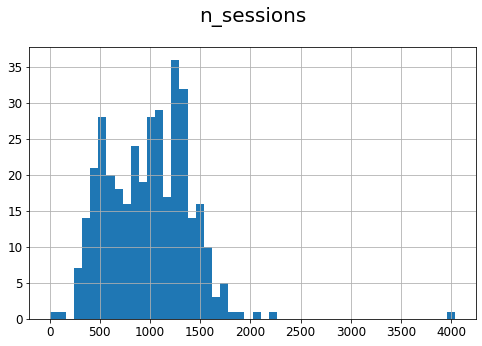

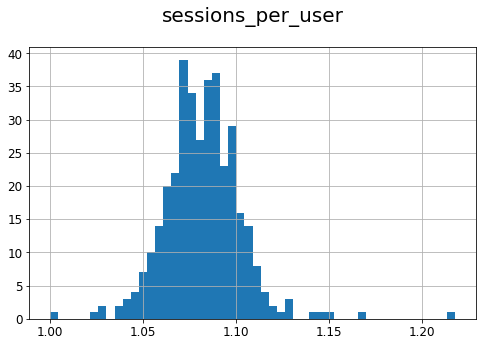

In [28]:
for col in ['n_sessions', 'sessions_per_user']:
    sessions_per_user[col].hist(bins=50)
    plt.title(col)
    plt.show()

В обоих случаях есть выбросы, поэтому посчитаем медиану:

In [29]:
for col in ['n_sessions', 'sessions_per_user']:  
    print('{} (median): {}'.format(col, sessions_per_user[col].median().round().astype('int')))

n_sessions (median): 1003
sessions_per_user (median): 1


**г) Среднее количество сессий в день на одного пользователя в динамике по месяцам**

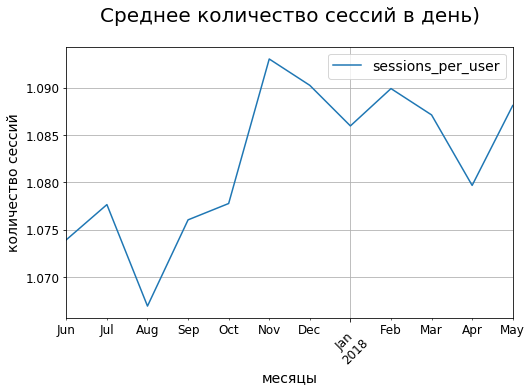

In [30]:
sessions_per_user.groupby('month').agg({'sessions_per_user':'mean'}).plot(grid=True)
plt.title('Среднее количество сессий в день)')
plt.xlabel('месяцы')
plt.ylabel('количество сессий')
# plt.ylim(0, 2) # в данном случае это не нужно, так как становится ненаглядно (узкий диапазон колебаний)
plt.xticks(rotation=45)
plt.show()

#### 3. Сколько длится одна сессия (ASL)

Посчитаем длину всех сессий и посмотрим распределение, чтобы выбрать подходящую меру среднего:

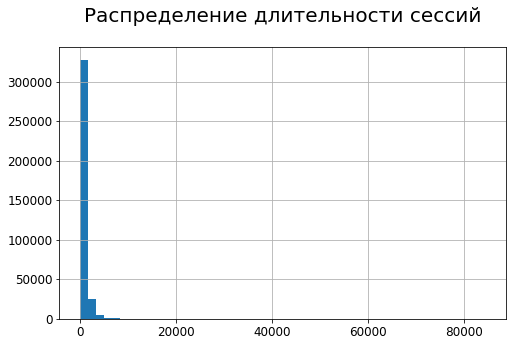

In [31]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

visits['session_duration_sec'].hist(bins=50)
plt.title('Распределение длительности сессий')
plt.show()

Распределение далеко от нормального, много нулевых значений, поэтому среднее или медиана нам не подходят – будем считать моду:

In [32]:
metrics_val['session_duration_sec_mode'] = visits['session_duration_sec'].mode()[0]
print('ASL (средняя продолжительность сессии): {} секунд'.format(metrics_val['session_duration_sec_mode']))

ASL (средняя продолжительность сессии): 60 секунд


#### 4. Retention Rate

Для расчета Retention выделим когорты:
- Событие – первый визит,
- Период – месяц,
- lifetime – тоже месяц.

*Допущение: считаем, что в нашем датасете данные только по новым пользователям за период, тогда первый визит пользователя в датасете является первым за все время жизни пользователя.*

1. Сохраним дату первого визита для каждого пользователя, и объединим эти данные с исходным датафреймом `visits`:

In [33]:
first_visit_date = visits.groupby(['uid'])['session_date'].min()

# переименуем колонку в Series
first_visit_date.name = 'first_visit_date'

# присоединим колонку 'first_visit_date' к данным о визитах
visits = visits.join(first_visit_date, on='uid')

In [34]:
visits.sample(5)

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec,first_visit_date
328485,touch,2017-12-24 13:11:00,4,2017-12-24 13:10:00,18221587795462734289,2017,12,51,2017-12-24,60,2017-12-24
284066,desktop,2017-10-04 20:25:00,5,2017-10-04 20:02:00,5903649700142894681,2017,10,40,2017-10-04,1380,2017-10-04
356679,desktop,2018-03-01 15:16:00,4,2018-03-01 14:59:00,17814509931433028201,2018,3,9,2018-03-01,1020,2018-03-01
278162,desktop,2017-10-14 12:35:00,4,2017-10-14 12:27:00,718916411068438158,2017,10,41,2017-10-14,480,2017-10-14
319025,desktop,2017-11-08 23:55:00,1,2017-11-08 23:29:00,15733990899101691242,2017,11,45,2017-11-08,1560,2017-08-07


2. Выделим из даты первого визита месяц, чтобы в дальнейшем мы могли группировать визиты по когортам:

In [35]:
visits['first_visit_month'] = visits['first_visit_date'].astype('datetime64[M]')
visits.sample(5)

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec,first_visit_date,first_visit_month
345561,desktop,2017-11-24 15:32:00,9,2017-11-24 15:28:00,254488308154432021,2017,11,47,2017-11-24,240,2017-09-21,2017-09-01
3685,touch,2018-05-16 22:07:00,3,2018-05-16 22:04:00,5837497248171809126,2018,5,20,2018-05-16,180,2018-05-16,2018-05-01
8087,desktop,2017-12-13 00:40:00,4,2017-12-13 00:37:00,7116768589531147186,2017,12,50,2017-12-13,180,2017-12-13,2017-12-01
154703,desktop,2018-03-22 10:23:00,4,2018-03-22 10:21:00,5603453646174104178,2018,3,12,2018-03-22,120,2017-06-01,2017-06-01
92235,desktop,2017-09-05 10:51:00,4,2017-09-05 10:14:00,3212511000568946038,2017,9,36,2017-09-05,2220,2017-09-05,2017-09-01


3. Для каждой строки датафрейма рассчитаем период `lifetime`, в рамках котрого был совершен визит:

In [36]:
# для каждого визита: считаем разницу между датой визита и датой первого визита
visits['cohort_lifetime'] = visits['session_date'] - visits['first_visit_date']

# считаем, сколько целых месяцев
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')

# округляем и сохраняем как целое число
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

visits.sample(5)

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec,first_visit_date,first_visit_month,cohort_lifetime
63716,desktop,2017-12-20 18:28:00,3,2017-12-20 18:27:00,2424000413043272732,2017,12,51,2017-12-20,60,2017-12-20,2017-12-01,0
23981,touch,2017-12-27 13:34:00,4,2017-12-27 13:31:00,10170987390738761189,2017,12,52,2017-12-27,180,2017-12-27,2017-12-01,0
204298,touch,2017-12-05 17:56:00,3,2017-12-05 17:54:00,1113613485236192641,2017,12,49,2017-12-05,120,2017-11-21,2017-11-01,0
141146,desktop,2018-02-09 22:09:00,3,2018-02-09 22:08:00,813635488124910616,2018,2,6,2018-02-09,60,2018-02-09,2018-02-01,0
209383,touch,2017-12-01 07:46:00,3,2017-12-01 07:40:00,11743273749025101786,2017,12,48,2017-12-01,360,2017-10-20,2017-10-01,1


4. Сгруппируем данные по когорте (`first_visit_month`) и времени жизни (`cohort_lifetime`). Посчитаем для каждой когорты количество активных пользователей на каждый месяц жизни:

In [37]:
visits_by_month = visits.groupby(['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
visits_by_month.sample(5)

,first_visit_month,cohort_lifetime,uid
13,2017-07-01,0,13140
1,2017-06-01,1,976
70,2018-01-01,0,22624
2,2017-06-01,2,718
19,2017-07-01,6,587


5. Найдём исходное количество пользователей в каждой когорте (количество уникальных пользователей на нулевую неделю `cohort_lifetime`):

In [38]:
initial_users_count = visits_by_month[visits_by_month['cohort_lifetime'] == 0][['first_visit_month', 'uid']]

# переименуем столбец uid
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 
initial_users_count

,first_visit_month,cohort_users
0,2017-06-01,13259
13,2017-07-01,13140
25,2017-08-01,10181
36,2017-09-01,16704
46,2017-10-01,25977
55,2017-11-01,27248
63,2017-12-01,25268
70,2018-01-01,22624
76,2018-02-01,22197
81,2018-03-01,20589


6. Объединим данные по визитам по месяцам с исходным количеством пользователей в когорте и посчитаем `retention rate`:

In [39]:
cohorts = visits_by_month.merge(initial_users_count, on = 'first_visit_month')
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

In [40]:
cohorts

,first_visit_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.00
1,2017-06-01,1,976,13259,0.07
2,2017-06-01,2,718,13259,0.05
3,2017-06-01,3,805,13259,0.06
4,2017-06-01,4,910,13259,0.07
...,...,...,...,...,...
85,2018-04-01,0,15709,15709,1.00
86,2018-04-01,1,622,15709,0.04
87,2018-04-01,2,68,15709,0.00
88,2018-05-01,0,15273,15273,1.00


7. Построим сводную таблицу и создадим тепловую карту:

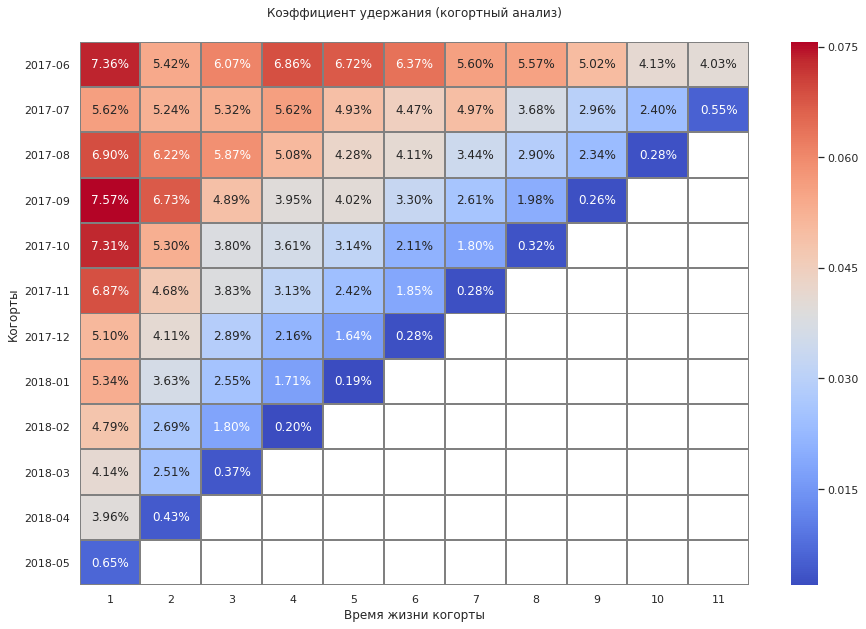

In [41]:
retention_pivot = cohorts.pivot_table(index='first_visit_month', columns='cohort_lifetime', \
                                      values='retention', aggfunc='sum')

# для наглядности уберем нулевой месяц, так как во всех когортах Retention в месяц привлечения равен 100%
make_heatmap(retention_pivot[~retention_pivot[1].isna()][range(1, 12)], 'Коэффициент удержания (когортный анализ)', \
             fmt='.2%')

### Промежуточные выводы

В разделе метрик по продукту мы посчитали следующие метрики:

- Средняя аудитория (количество уникальных пользователей):
  - DAU = 908,
  - WAU = 5 716,
  - MAU = 23 228;
- Пик посещаемости пришелся на декабрь 2017 года;
- Минимальный DAU был 31 марта 2018 года (1 пользователь) – скорее всего, произошел какой-то сбой в системе сбора аналитики, или не работал сам продукт;
- Максимальный DAU пришелся на 24 ноября 2017 года (3319 пользователей).

- Показатели посещаемости лучше с десктопа (разница более, чем в два раза); динамика посещаемости с десктопа и мобильных устройств по месяцам носит схожий характер.

- По источникам привлечения: выше всего показатели посещаемости у источников 4, 3, 5, хуже всего – 6 и 7; динамика посещаемости также схожая;

- sticky factor:
  - wau = 16%,
  - mau = 4%
  - Динамика sticky factor (DAU / MAU) носит такой же характер, как у динамики DAU.

- Количество сессий в день:
  - Среднее количество сессиий в день: 987,
  - Динамика по месяцам: характер кривой похож на MAU,
  - На одного пользователя: 1 (поэтому кривые MAU и количества сессий почти одинаковые);

- ASL (средняя продолжительность сессии по моде): 60 секунд;

- Retention:
  - Самый высокий retention в первый месяц (следующий за нулевым) у когорт, пришедших в сентябре 2017 (7.57), июне 2017 (7.36) и октябре 2017 (7.31);
  - В целом наилучшие показатели у когорты июня 2017.

<div align='right'><a href='#content'>↑ В начало проекта ↑</a></div>

---

### <a id='metrics_sales'>2.2. Показатели по продажам</a>

Перед расчетом продуктовых метрик подготовим таблицу по покупателям, в которой будет вся необходимая информация.

Добавим столбцы в таблицу `orders`:

In [42]:
# для расчетов количества заказов в месяц
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders.sample(5)

,buy_ts,revenue,uid,order_month
14989,2017-10-28 09:01:00,3.42,15399671142084715157,2017-10-01
47915,2018-05-18 19:33:00,1.53,17728217260034293905,2018-05-01
25506,2017-12-22 22:03:00,1.53,334412847429939699,2017-12-01
43686,2018-04-10 15:45:00,2.14,6166747268563050393,2018-04-01
39452,2018-03-11 18:19:00,9.45,8347295037998854285,2018-03-01


In [43]:
# для формирования когорт по месяцу первого заказа
fisrt_orders = (orders
                .groupby(['uid'])
                .agg({'order_month':'min'})
                .rename(columns = {'order_month':'first_order_month'}))

orders = orders.merge(fisrt_orders, on='uid')

In [44]:
orders.sample(5)

,buy_ts,revenue,uid,order_month,first_order_month
44805,2018-04-05 18:13:00,1.22,2810329616995218986,2018-04-01,2018-04-01
7100,2017-07-27 22:29:00,1.83,10864105665346083988,2017-07-01,2017-07-01
11157,2017-09-15 15:56:00,6.11,14921977453219162995,2017-09-01,2017-09-01
26243,2017-12-06 06:10:00,0.03,11519089408305428591,2017-12-01,2017-12-01
36220,2018-02-05 10:34:00,4.37,6279936374223017739,2018-02-01,2018-02-01


Для расчетов метрик, связанных с продажами (количество покупок, LTV, ROI), соберем таблицу, в которой будут все необходимые данные по покупателям:
- `uid` – уникальный идентификатор покупателя (возьмем из таблицы `orders`);
- `revenue` – выручка с каждого заказа покупателей;
- `order_month` – месяц каждого заказа;
- `lifetime` – по каждому заказу каждого покупателя: месяц жизни покупателя, в который был совершен заказ (разница между `order_month` и `first_order_month` в целых месяцах);
- Атрибуты для срезов и когорт:
  - `first_visit_month` – месяц первого визита (одноименный столбец из таблицы `visists`),
  - `first_order_month` – месяц первого заказа (одноименный столбец из таблицы `orders`),
  - `source_id` – источник, откуда пришел покупатель (значение в столбце `source_id` таблицы `visits` для первой сессии покупателя),
  - `device` – устройство, с которого пользователь совершил первый визит (значение в столбце `device` таблицы `visits` для первой сессии покупателя).

In [45]:
# покупатели: uid + месяц первого заказа
payers = orders.groupby('uid').agg({'first_order_month': 'min'})
payers.sample(5)

,first_order_month
uid,
8448665899013067026,2018-05-01
1272208317149006706,2017-11-01
4471776915779429335,2017-09-01
11508982896278814550,2017-12-01
16492533638233881663,2018-02-01


In [46]:
# посетители: uid + месяц первого визита
users = visits.groupby(['uid']).agg({'first_visit_month':'min'})
users.sample(5)

,first_visit_month
uid,
17666680556326599845,2017-06-01
329770234787658306,2017-12-01
15284828650131857956,2017-10-01
2654238586588116739,2018-05-01
12878049940108579445,2017-07-01


In [47]:
# присоединяем к покупателям дату первого визита
payers_visits = payers.merge(users, on='uid')
payers_visits.sample(5)

,first_order_month,first_visit_month
uid,,
6487078860810947263,2018-01-01,2017-06-01
9101055664816176948,2017-06-01,2017-06-01
8282109421173799144,2018-01-01,2018-01-01
3357062870524537488,2018-03-01,2018-03-01
833373847049262008,2017-11-01,2017-11-01


In [48]:
# присоединяем к покупателям заказы
payers_orders = payers_visits.merge(orders[['uid', 'order_month', 'revenue']], on = 'uid')

payers_orders.sample(5)

,uid,first_order_month,first_visit_month,order_month,revenue
34730,12512874522950560371,2018-05-01,2018-05-01,2018-05-01,6.72
22458,7953376971237044409,2017-11-01,2017-11-01,2018-02-01,0.73
4868,1791971029818385061,2017-12-01,2017-12-01,2017-12-01,1.83
1811,658843619254696322,2018-05-01,2018-05-01,2018-05-01,0.73
23990,8554616267537059038,2017-11-01,2017-11-01,2017-11-01,1.53


In [49]:
# для каждого заказа считаем месяц lifetime, в который заказ совершен
payers_orders['lifetime'] = ((payers_orders['order_month'] - payers_orders['first_order_month'])\
                             / np.timedelta64(1,'M')).round().astype(int)

payers_orders.sample(5)

,uid,first_order_month,first_visit_month,order_month,revenue,lifetime
13508,4888896412881682629,2018-03-01,2018-03-01,2018-03-01,9.17,0
21984,7766719474765136465,2017-11-01,2017-11-01,2017-11-01,14.67,0
33004,11920452646463905188,2017-06-01,2017-06-01,2017-10-01,9.41,4
25668,9279446112957077103,2018-03-01,2018-03-01,2018-03-01,4.08,0
2761,1045563945909413785,2018-01-01,2018-01-01,2018-01-01,0.79,0


In [50]:
# источник для каждого посетителя
attr_source = visits.sort_values(by = ['uid', 'start_ts']).groupby(['uid']).agg({'source_id': 'first'})

# устройство для каждого посетителя
attr_device = visits.sort_values(by = ['uid', 'start_ts']).groupby(['uid']).agg({'device': 'first'})

# присоединяем к покупателям значения атрибутов (first_order_month у нас уже есть)
payers_orders_attr = payers_orders.merge(attr_source, on = 'uid').merge(attr_device, on = 'uid')
payers_orders_attr.sample(5)

,uid,first_order_month,first_visit_month,order_month,revenue,lifetime,source_id,device
49020,17947414389933427763,2017-07-01,2017-07-01,2017-07-01,0.37,0,4,desktop
24792,8926058188367158751,2017-12-01,2017-12-01,2017-12-01,11.73,0,5,desktop
12438,4459830579298777915,2017-09-01,2017-09-01,2017-09-01,4.58,0,4,touch
5193,1906172326262950477,2017-06-01,2017-06-01,2017-06-01,2.44,0,9,desktop
43618,15754169230098079149,2018-03-01,2018-03-01,2018-03-01,3.67,0,3,touch


Функция для расчета **размеров когорт** по заданному признаку:

In [51]:
def cohort_size_calc(attr):
    cohorts_size = (payers_orders_attr
                .groupby([attr])['uid'].nunique()
                .reset_index()
                .rename(columns={'uid':'cohort_size'}))
    return cohorts_size

---

#### 1. Когда люди начинают покупать

Первый визит для каждого пользователя:

In [52]:
fisrt_visits = visits.sort_values(by=['uid','session_date']).groupby(['uid']).agg({'start_ts':'min'})
fisrt_visits.head(5)

,start_ts
uid,
11863502262781,2018-03-01 17:27:00
49537067089222,2018-02-06 15:55:00
297729379853735,2017-06-07 18:47:00
313578113262317,2017-09-18 22:49:00
325320750514679,2017-09-30 14:29:00


Присоединяем первый заказ для каждого покупателя:

In [53]:
time_to_order = (fisrt_visits.join(orders.sort_values(by=['uid','buy_ts'])
                                    .groupby(['uid'])
                                    .agg({'buy_ts':'first'})))
time_to_order = time_to_order.dropna()
time_to_order.sample(5)

,start_ts,buy_ts
uid,,
1498897499944394483,2017-12-15 20:17:00,2017-12-16 01:08:00
3970288997536065528,2018-05-03 22:03:00,2018-05-03 22:13:00
6692805555610155085,2017-07-19 15:15:00,2017-07-19 16:00:00
12784532572489265006,2017-09-15 10:51:00,2017-09-15 11:03:00
5618853531606560635,2017-07-31 09:26:00,2017-08-28 19:32:00


Считаем дельту в минутах:

In [54]:
time_to_order['time_to_order'] = (time_to_order['buy_ts'] - time_to_order['start_ts']).dt.total_seconds() // 60
time_to_order.describe()

,time_to_order
count,36523.00
mean,24340.18
std,67784.77
min,0.00
25%,4.00
50%,16.00
75%,2897.00
max,523144.00


Половина пользователей совершает первую покупку в течение 16 минут.

#### 2. Сколько раз покупают за период

Будем использовать созданную ранее таблицу с данными по покупателям и их заказам:

In [55]:
payers_orders_attr.head()

,uid,first_order_month,first_visit_month,order_month,revenue,lifetime,source_id,device
0,313578113262317,2018-01-01,2017-09-01,2018-01-01,0.55,0,2,desktop
1,1575281904278712,2017-06-01,2017-06-01,2017-06-01,1.22,0,10,touch
2,1575281904278712,2017-06-01,2017-06-01,2017-06-01,1.83,0,10,touch
3,2429014661409475,2017-10-01,2017-10-01,2017-10-01,73.33,0,3,desktop
4,2464366381792757,2018-01-01,2018-01-01,2018-01-01,2.44,0,5,desktop


**а) Среднее количество покупок в месяц по всем покупателям:**

In [56]:
orders_by_month = payers_orders_attr.groupby(['uid','order_month']).agg({'revenue':'count'})
print('Среднее количество покупок в месяц: {}'.format(orders_by_month['revenue'].mean().round(2)))

Среднее количество покупок в месяц: 1.23


**б) Среднее количество покупок в месяц, когортный анализ:**

Посчитаем количество заказов, совершенных каждым пользователем по месяцам жизни:

In [57]:
orders_per_lifetime = payers_orders_attr.groupby(['uid', 'lifetime']).agg({'revenue':'count'}).reset_index()
orders_per_lifetime = orders_per_lifetime.rename(columns={'revenue':'orders_per_lifetime'})
orders_per_lifetime.sample(5)

,uid,lifetime,orders_per_lifetime
28445,12771727587844704468,0,1
38424,17292770885776470875,0,1
10846,4876963227263996600,0,1
29580,13270136720044955879,0,1
25575,11486795902796978481,0,1


Соединим данные о покупателях (uid и месяц первого заказа) и количество заказов по месяцам жизни:

In [58]:
# группируем данные по uid и lifetime, чтобы не было задвоений строк, когда у пользователя несколько заказов в одном lifetime
group_lifetime = payers_orders_attr.groupby(['uid','lifetime']).agg({'first_order_month':'first'}).reset_index()

In [59]:
orders_per_users = group_lifetime.merge(orders_per_lifetime, on=['uid', 'lifetime'])
orders_per_users.head(5)

,uid,lifetime,first_order_month,orders_per_lifetime
0,313578113262317,0,2018-01-01,1
1,1575281904278712,0,2017-06-01,2
2,2429014661409475,0,2017-10-01,1
3,2464366381792757,0,2018-01-01,1
4,2551852515556206,0,2017-11-01,2


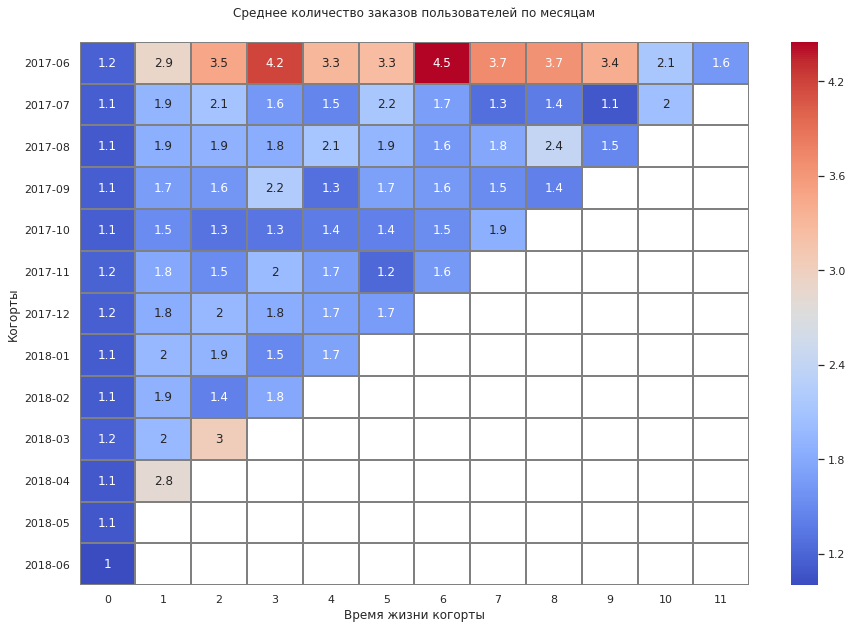

In [60]:
# соберем pivot и посчитаем среднее количество заказов на одного пользователя в течение жизни когорты
orders_pivot = orders_per_users.pivot_table(index='first_order_month', columns='lifetime', \
                                              values='orders_per_lifetime', aggfunc='mean')

make_heatmap(orders_pivot, 'Среднее количество заказов пользователей по месяцам')

Почему-то есть провал для когорты, совершившей первый заказ в августе 2017, в 10-ый месяц lifetime. Проверим, действительно ли нет заказов:

In [61]:
orders_per_users.query('first_order_month == "2017-08-01" & lifetime==10')

,uid,lifetime,first_order_month,orders_per_lifetime


Дейтвительно, ни один покупатель из этой когорты не сделал в 10-ый месяц lifetime ни одного заказа.

**в) Среднее количество покупок в месяц в разрезах по источникам привлечения и устройствам пользователей:**

Среднее количество покупок в месяц в разрезе по source_id:


,orders_per_month
source_id,
1,1.53
2,1.51
5,1.23
9,1.19
3,1.15
4,1.13
10,1.11
7,1.00


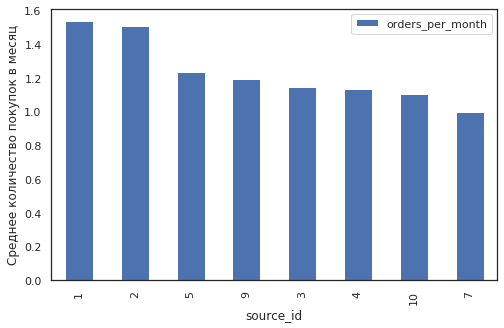

Среднее количество покупок в месяц в разрезе по device:


,orders_per_month
device,
desktop,1.24
touch,1.18


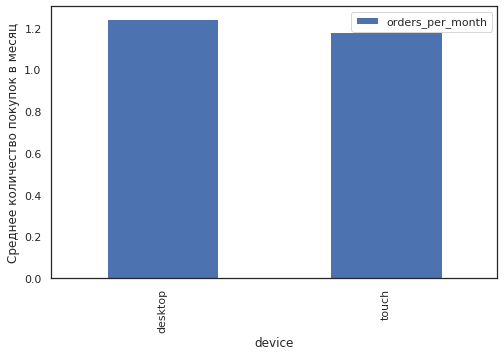

In [62]:
for attr in ['source_id', 'device']:
    orders_by_attr = payers_orders_attr.groupby([attr,'uid','order_month']).agg({'revenue':'count'})
    
    orders_by_attr_pivot = orders_by_attr.pivot_table(index=attr, values='revenue', aggfunc='mean')
    orders_by_attr_pivot = orders_by_attr_pivot.rename(columns={'revenue':'orders_per_month'})
    orders_by_attr_pivot_sorted = orders_by_attr_pivot.sort_values(by='orders_per_month', ascending=False)
    
    print('Среднее количество покупок в месяц в разрезе по {}:'.format(attr))
    display(orders_by_attr_pivot_sorted)
    
    orders_by_attr_pivot_sorted.plot(kind='bar')
    plt.ylabel('Среднее количество покупок в месяц')
    plt.show()

#### 3. Средний чек

Понимаем под средним чеком среднюю выручку с одного покупателя за период (так считать подсказал предподаватель).

**а) Средний чек за весь период по всем покупателям:**

In [63]:
# сначала суммируем по покупателям, потом находим среднее
check_average = orders.groupby(['uid']).agg({'revenue':'sum'})['revenue'].mean().round(2)
print('Средний чек за весь период: {} y.e.'.format(check_average))

Средний чек за весь период: 6.9 y.e.


**б) Динамика среднего чека по месяцам:**

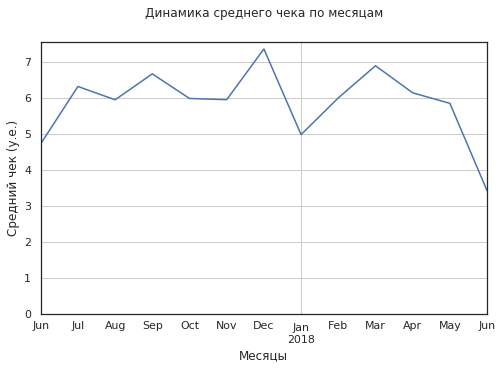

In [64]:
# суммируем по месяцам, внутри месяцев - по покупателям
check_average_month = payers_orders_attr.groupby(['order_month', 'uid']).agg({'revenue':'sum'}).reset_index()

# считаем среднее для каждого месяца
(
    check_average_month
    .groupby(['order_month'])
    .agg(check_average = ('revenue', 'mean'))
    .plot(grid=True, legend=False)
)

plt.title('Динамика среднего чека по месяцам')
plt.ylim(bottom=0)
plt.xlabel('Месяцы')
plt.ylabel('Средний чек (y.e.)')
plt.show()

**в) Средний чек в разрезах по источникам привлечения и устройствам пользователей:**

Средний чек в разрезе по source_id:


,revenue
source_id,
2,13.38
1,10.72
5,7.59
4,5.51
9,5.29
3,5.20
10,3.35
7,1.22


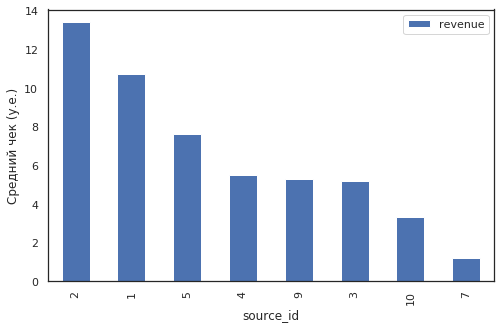

Средний чек в разрезе по device:


,revenue
device,
desktop,7.23
touch,5.57


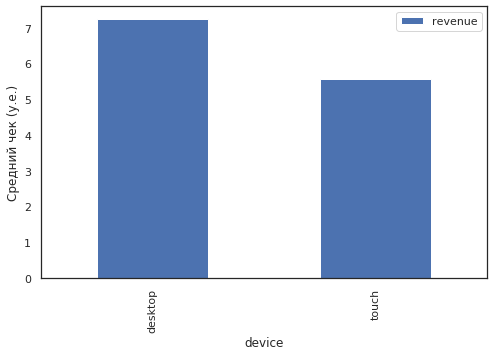

In [65]:
for attr in ['source_id', 'device']:
    bill_by_attr = payers_orders_attr.groupby([attr,'uid']).agg({'revenue':'sum'})
    
    bill_by_attr_pivot = bill_by_attr.pivot_table(index=attr, values='revenue', aggfunc='mean')
    bill_by_attr_pivot_sorted = bill_by_attr_pivot.sort_values(by='revenue', ascending=False)
    
    print('Средний чек в разрезе по {}:'.format(attr))
    display(bill_by_attr_pivot_sorted)
    
    bill_by_attr_pivot_sorted.plot(kind='bar')
    plt.ylabel('Средний чек (y.e.)')
    plt.show()

#### 4. Сколько денег приносят (LTV)

Здесь посчитаем **средний LTV за полгода**, а когортный анализ проведем в разделе 2.3. Маркетинг (LTV в связке с CAC и ROI).

1. Сгруппируем таблицу с данными о покупателях и их заказах по месяцу первой покупки и месяцу lifetime и сложим выручку:

In [66]:
revenue_per_lifetime = (payers_orders_attr
                        .groupby(['first_order_month', 'lifetime'])
                        .agg({'revenue': 'sum'})
                        .reset_index())
revenue_per_lifetime

,first_order_month,lifetime,revenue
0,2017-06-01,0,9557.49
1,2017-06-01,1,981.82
2,2017-06-01,2,885.34
3,2017-06-01,3,1931.30
4,2017-06-01,4,2068.58
...,...,...,...
74,2018-03-01,2,1114.87
75,2018-04-01,0,10600.69
76,2018-04-01,1,1209.92
77,2018-05-01,0,13925.76


2. Посчитаем количество новых покупателей за каждый месяц (размеры когорт):

In [67]:
cohort_sizes_time = cohort_size_calc('first_order_month')
cohort_sizes_time

,first_order_month,cohort_size
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340
5,2017-11-01,4081
6,2017-12-01,4383
7,2018-01-01,3373
8,2018-02-01,3651
9,2018-03-01,3533


3. Соединим размеры когорт и данные по суммарной выручке по lifetime:

In [68]:
orders_for_cohorts = pd.merge(revenue_per_lifetime, cohort_sizes_time, on='first_order_month')
orders_for_cohorts

,first_order_month,lifetime,revenue,cohort_size
0,2017-06-01,0,9557.49,2023
1,2017-06-01,1,981.82,2023
2,2017-06-01,2,885.34,2023
3,2017-06-01,3,1931.30,2023
4,2017-06-01,4,2068.58,2023
...,...,...,...,...
74,2018-03-01,2,1114.87,3533
75,2018-04-01,0,10600.69,2276
76,2018-04-01,1,1209.92,2276
77,2018-05-01,0,13925.76,2988


4. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте:

In [69]:
orders_for_cohorts['ltv'] = orders_for_cohorts['revenue'] / orders_for_cohorts['cohort_size']
orders_for_cohorts.sample(5)

,first_order_month,lifetime,revenue,cohort_size,ltv
74,2018-03-01,2,1114.87,3533,0.32
35,2017-09-01,2,1344.52,2581,0.52
55,2017-11-01,5,219.88,4081,0.05
26,2017-08-01,3,536.05,1370,0.39
11,2017-06-01,11,519.62,2023,0.26


5. Рассчитаем накопительную сумму, чтобы получить LTV:

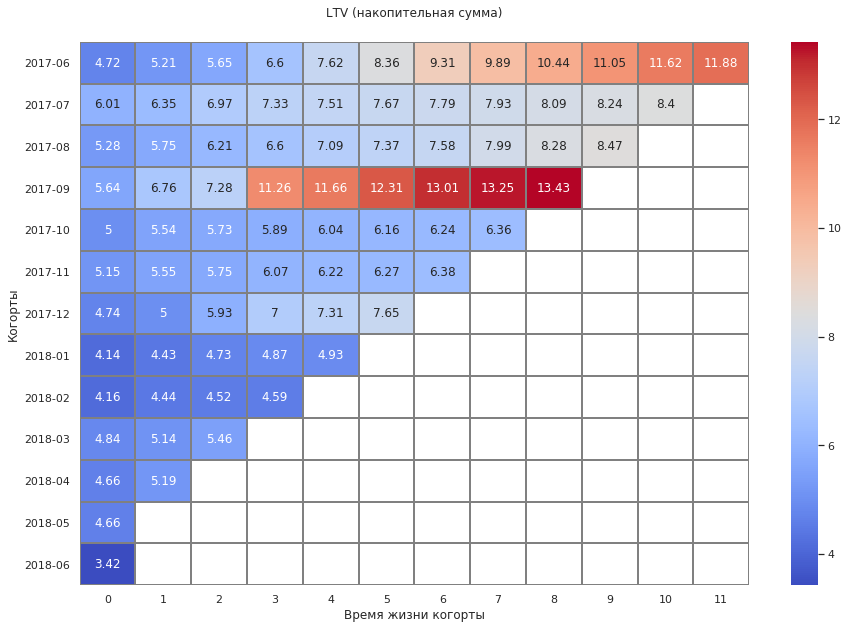

In [70]:
# собираем сводную таблицу, где значения = средняя выручка на пользователя за каждый месяц жизни
output_ltv = orders_for_cohorts.pivot_table(index='first_order_month', columns='lifetime', \
                                            values='ltv', aggfunc='sum').round(2)

# считаем накопительную сумму, чтобы в последней ячейке по каждой когорте был LTV
output_ltv = output_ltv.cumsum(axis=1)

make_heatmap(output_ltv, 'LTV (накопительная сумма)', fmt='.4g')

6. Посчитаем средний LTV за полгода. Для этого нам надо:
   - Отсечь когорты, которые прожили меньше полугода;
   - Отсечь месяцы жизни с 6 по 11.

In [71]:
# range(0,6) = первые шесть столбцов
# dropna() = убираем строки с пропусками (= когорты, которые еще не прожили полгода)
ltv_half_year = output_ltv[range(0,6)].dropna()
ltv_half_year

lifetime,0,1,2,3,4,5
first_order_month,,,,,,
2017-06-01,4.72,5.21,5.65,6.60,7.62,8.36
2017-07-01,6.01,6.35,6.97,7.33,7.51,7.67
2017-08-01,5.28,5.75,6.21,6.60,7.09,7.37
2017-09-01,5.64,6.76,7.28,11.26,11.66,12.31
2017-10-01,5.00,5.54,5.73,5.89,6.04,6.16
2017-11-01,5.15,5.55,5.75,6.07,6.22,6.27
2017-12-01,4.74,5.00,5.93,7.00,7.31,7.65


7. Посчитаем средний LTV за полгода. Не уверена, как считать правильно, поэтому выложу два варианта:

Вариант а) считаем среднее по получившейся выше табличке (получается среднее от среднего):

In [72]:
ltv_mean_a = ltv_half_year[5].mean().round(2)
print('Средний LTV за полгода: {} y.e.'.format(ltv_mean_a))

Средний LTV за полгода: 7.97 y.e.


Вариант б) считаем среднее по lifetime каждой когорты:

In [73]:
ltv_half_year_mean = (orders_for_cohorts
                      .query('first_order_month <= "2017-12-01" & lifetime < 6')
                      .groupby(['first_order_month'])
                      .agg({'cohort_size':'first', 'revenue':'sum'}))

ltv_mean_b = (ltv_half_year_mean['revenue'].sum() / ltv_half_year_mean['cohort_size'].sum()).round(2)
print('Средний LTV за полгода: {} y.e.'.format(ltv_mean_b))

Средний LTV за полгода: 7.7 y.e.


### Промежуточные выводы

На этапе анализа продаж мы посчитали следующие метрики:

- Половина пользователей совершает первую покупку в течение 16 минут после начала первого визита;

- Среднее количество покупок в месяц:
  - На одного покупателя: 1.23,
  - Лучше всего показатели когорты, пришедшей в июне 2017, – 3-4 покупки в месяц,
  - Больше покупают пользователи, пришедшие из источников 1 и 2, остальные примерно вровень,
  - По устройствам нет особых различий;

- Средний чек:
  - За весь период: 6.9 y.e.,
  - В январе средний чек падает, после новогодних праздников начинает расти, достигает пика к декабрю (видимо, покупают билеты на мероприятия в качестве подарков),
  - К концу анализируемого периода наблюдаем снижение среднего чека,
  - Больше всего платят пользователи из источников 2 (13.38), 7 (11.22) и 1 (10.72),  
  - С десктопа платят больше (7.23 против 5.57 у мобильных устройств),

- Средний LTV за полгода: 7.6 / 7.7 y.e.

<div align='right'><a href='#content'>↑ В начало проекта ↑</a></div>

---

### <a id='metrics_marketing'>2.3. Маркетинговые показатели</a>

Перед расчетом маркетинговых метрик посчитаем расходы в различных разрезах — это понадобится для когортного анализа LTV и ROI в этих же разрезах (месяц первой покупки, источник привлечения и устройство пользователя) и расчета других маркетинговых метрик:
- Для когорт по `first_order_month` и `source_id` группируем таблицу `costs` по соответствующему столбцу;
- Для когорт по `device` у нас нет данных в таблице `costs`, поэтому нужно поделить суммарные расходы в той же пропорции, что и количество покупателей в когортах по девайсам.

Выделим месяц из даты расходов, чтобы потом группировать расходы по месяцам и рассчитывать расходы по когортам:

In [74]:
costs['first_order_month'] = costs['dt'].astype('datetime64[M]')
costs.head()

,source_id,dt,costs,first_order_month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


Расходы по месяцам (`first_order_month`):

In [75]:
costs_month = costs.groupby(['first_order_month']).agg({'costs':'sum'}).reset_index()
costs_month

,first_order_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


Расходы по источникам (`source_id`):

In [76]:
costs_source = costs.groupby(['source_id']).agg({'costs':'sum'}).reset_index()
costs_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


Расходы по устройствам покупателей (`device`):

In [77]:
# считаем размеры когорт (воспользуемся ранее созданной функцией)
costs_device = cohort_size_calc('device')

# доля каждой когорты от общего количества покупателей
costs_device['%'] = (costs_device['cohort_size'] / costs_device['cohort_size'].sum())
costs_device

,device,cohort_size,%
0,desktop,29211,0.80
1,touch,7312,0.20


In [78]:
# считаем суммарные расходы
costs_total = costs['costs'].sum()

# разделим расходы в той же пропорции, что и количество пользователей в когортах по девайсам
for device in costs_device['device'].unique():
    costs_device.loc[costs_device['device'] == device, \
                            'costs'] = (costs_total * costs_device.query('device == @device')['%']).round(2)

costs_device

,device,cohort_size,%,costs
0,desktop,29211,0.80,263238.61
1,touch,7312,0.20,65893.01


In [79]:
# проверим расчеты
print(costs_total)
print(costs_device['costs'].sum())

329131.62
329131.62


---

#### 1. Когортный анализ LTV и ROI

Так как мы можем построить когорты по разным признакам (месяц первой покупки, источник привлечения и устройство пользователя), то для чистоты кода напишем функцию для когортного анализа LTV и ROI по разным признакам.

Функция будет **принимать на вход**:
- Признак для выделения когорт (`first_order_month`, `source_id` или `device`);
- Название датафрейма с суммарными расходами по когортам (их мы посчитали выше).

Функция будет **возвращать** тепловые карты для LTV и ROI (накопительные значения по месяцам жизни) и график для ROI.

**Алгоритм работы** функции:
1. В таблице с данными по покупателям рассчитываем по когортам:
   - `cohort_size` – размеры когорт (группировка по признаку выделения когорт и расчет количества пользователей), фиксированные значения по когортам;
   - `costs` – суммарные затраты на привлечение покупателей когорты;
   - `ltv` – частичка общего `ltv` от каждого заказа (= `revenue / cohort_size`);
   - `cac` – часть общих затрат (= `costs / cohort_size`);
   - `roi` – `ltv / cac * 100`.
   
   
2. По получившейся таблице строим сводные таблицы для расчета LTV и ROI:
   - `pivot_table` по соответствующему столбцу (`ltv` или `roi`) с `aggfunc = sum`;
   - `cumsum()` для расчета накопительной суммы по ходу жизни когорт;
   - построим визуализацию в виде тепловой карты (heatmap) и графика (для ROI). 

In [80]:
def ltv_roi_calc(attr, costs, figsize=(15,6)):
    # присоединяем к сборной табличке размеры когорт
    payers_orders_sizes = payers_orders_attr.merge(cohort_size_calc(attr), on=attr, how='left')
    
    # присоединяем расходы
    report = payers_orders_sizes.merge(costs[[attr, 'costs']], on=attr)
    
    # считаем кусочек ltv на каждый заказ
    report['ltv'] = report['revenue'] / report['cohort_size']
    
    # cac
    report['cac'] = report['costs'] / report['cohort_size']
    
    # roi
    report['roi'] = report['ltv'] / report['cac']
    
    
    # ----- LTV ----- #
    # на каждый месяц
    ltv_lifetime = report.pivot_table(index=attr, columns='lifetime', values='ltv', aggfunc='sum').fillna(0)
    
    # накопительный 
    ltv_lifetime = ltv_lifetime.cumsum(axis=1)
    
    # выводим красоту
    make_heatmap(ltv_lifetime, title=u'LTV по {}'.format(attr), fmt='.4g', figsize=figsize)
    
    
    # ----- ROI ----- #
    # на каждый месяц
    roi_lifetime = report.pivot_table(index=attr, columns='lifetime', values='roi', aggfunc='sum')
    roi_lifetime = roi_lifetime.fillna(0)
    
    # накопительный 
    roi_lifetime = roi_lifetime.cumsum(axis=1)
    
    # выводим красоту
    make_heatmap(roi_lifetime, title=u'ROI по {}'.format(attr), fmt='.1%', figsize=figsize)
    
    roi_lifetime.T.plot(grid=True, figsize=(10,5))
    plt.axhline(y=1, label=u'Уровень окупаемости', color='red', linestyle='--')
    
    # лимиты вертикальной оси (чтобы максимум был не меньше 1)
    max_value = roi_lifetime.max(axis=1).max()   
    if max_value > 1:
        ylim = max_value + max_value*0.05
    else:
        ylim = 1.05
    plt.ylim(0, ylim)
    
    # форматируем подписи в легенде для когорт по дате, чтобы был только год и месяц
    if '00:00' in str(roi_lifetime.index[0]):
        plt.legend(bbox_to_anchor=(1.05, 1), labels=roi_lifetime.index.strftime('%Y-%m'))
    else:
        plt.legend(bbox_to_anchor=(1.05, 1))
    
    plt.title(u'Окупаемость в разрезе по {}'.format(attr))
    plt.xlabel(u'Время жизни когорты')
    plt.ylabel('ROI')
    plt.show()
    
    return

Когортный анализ по месяцу первой покупки:

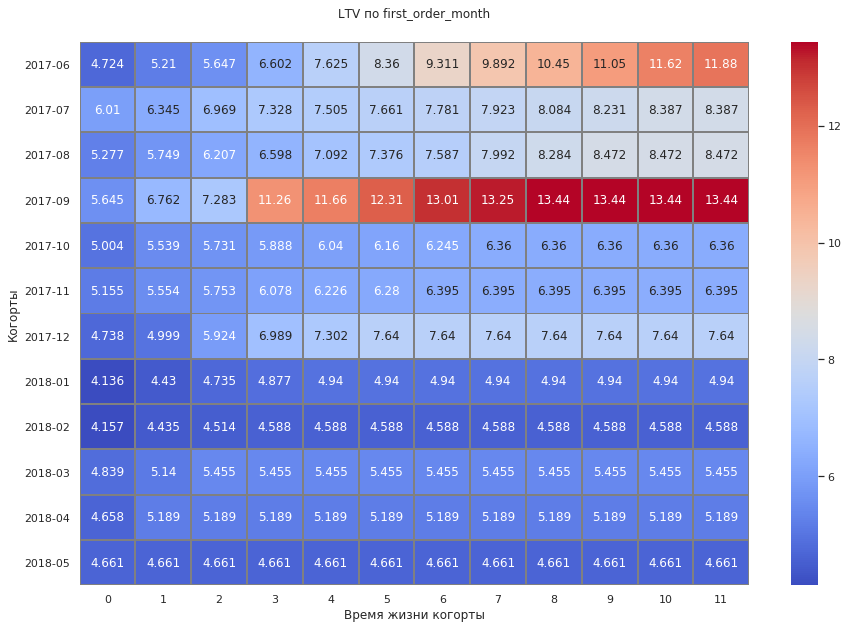

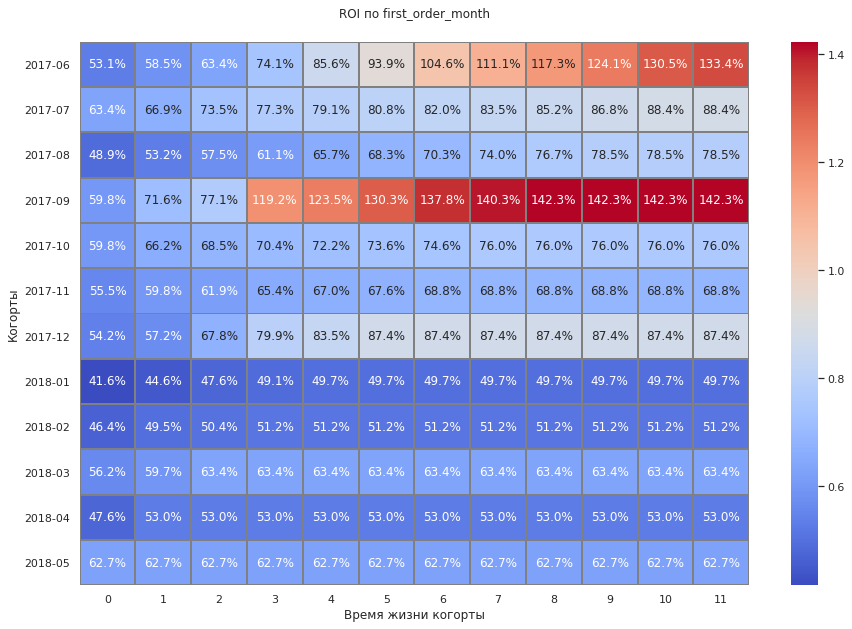

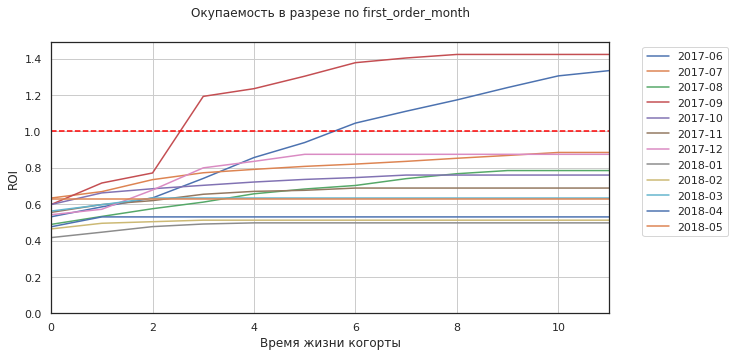

In [81]:
ltv_roi_calc('first_order_month', costs_month, figsize=(15,10))

Когортный анализ по источнику привлечения покупателя:

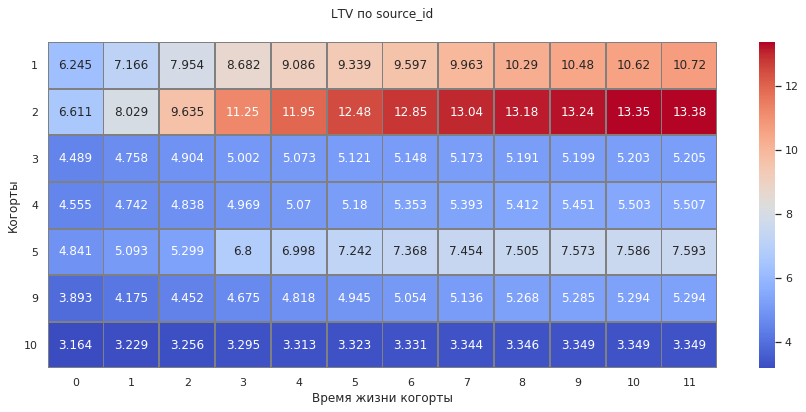

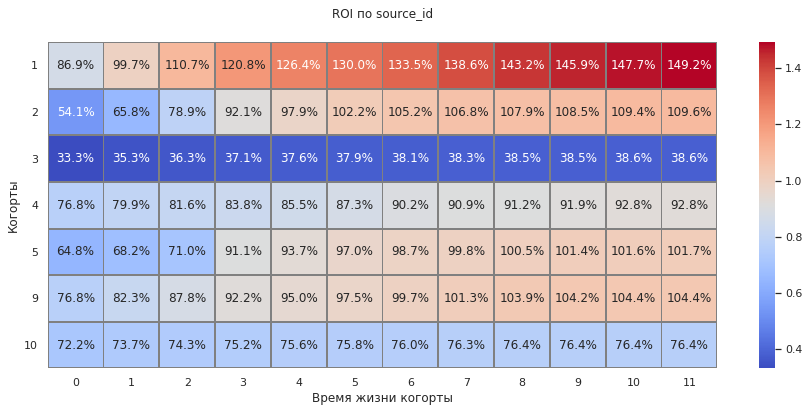

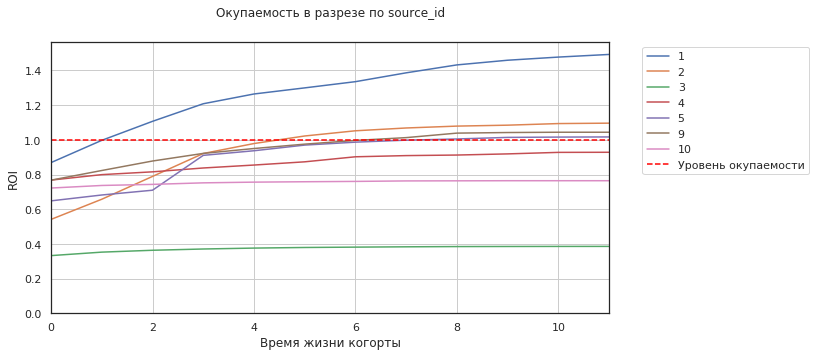

In [82]:
ltv_roi_calc('source_id', costs_source)

Когортный анализ по устройству покупателя:

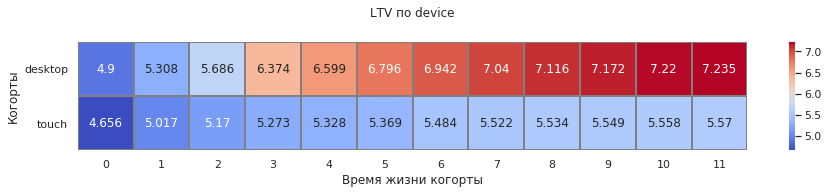

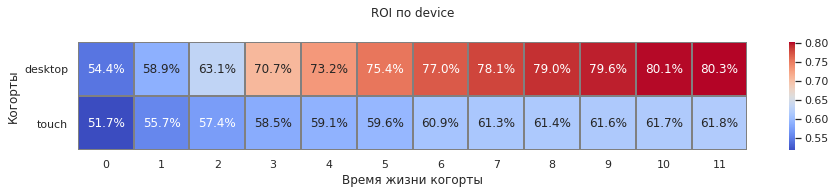

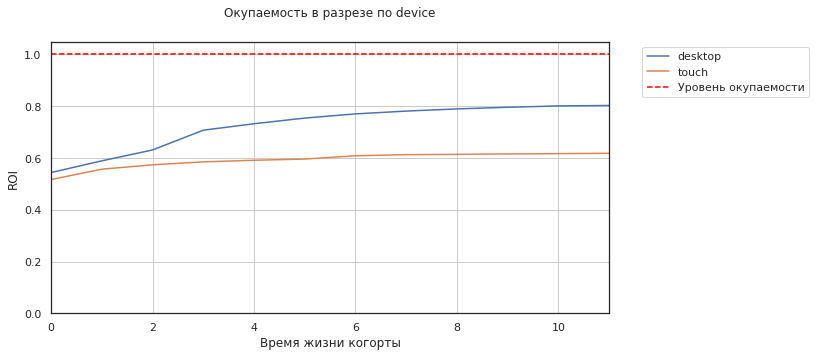

In [83]:
ltv_roi_calc('device', costs_device, figsize=(15,2))

---

#### 2. Сколько денег потратили (всего / на каждый источник / по времени)

**а) Суммарные расходы:**

In [84]:
print('Всего потратили {} y.e.'.format(costs['costs'].sum()))

Всего потратили 329131.62 y.e.


**б) Динамика расходов по месяцам:**

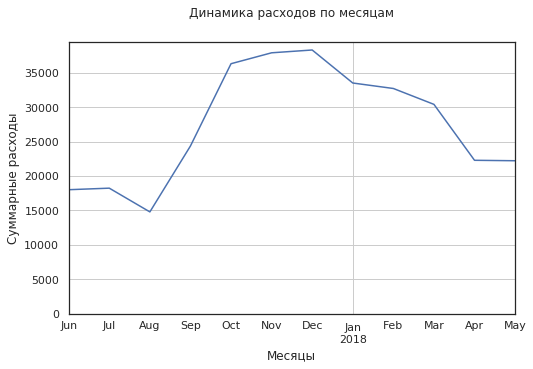

In [85]:
costs.groupby(['first_order_month'])['costs'].sum().plot(grid=True)
plt.title('Динамика расходов по месяцам')
plt.ylim(bottom=0)
plt.xlabel('Месяцы')
plt.ylabel('Суммарные расходы')
plt.show()
plt.show()

**в) Затраты в разбивке по источникам:**

Затраты в разбивке по источникам:


,source_id,costs
2,3,141321.63
3,4,61073.60
4,5,51757.10
1,2,42806.04
0,1,20833.27
6,10,5822.49
5,9,5517.49


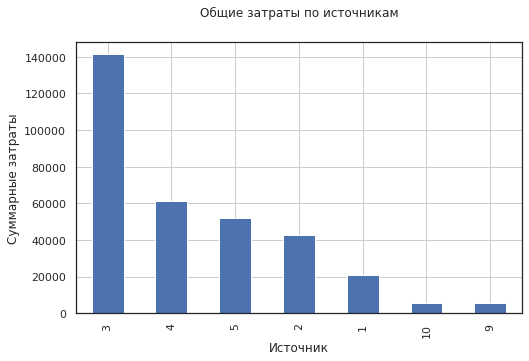

In [86]:
costs_source_sorted = costs_source.sort_values(by='costs', ascending=False)

print('Затраты в разбивке по источникам:')
display(costs_source_sorted)

costs_source_sorted.plot(kind='bar', x='source_id', y='costs', grid=True, legend=False)
plt.title('Общие затраты по источникам')
plt.xlabel('Источник')
plt.ylabel('Суммарные затраты')
plt.show()

Динамика расходов в разбивке по источникам:

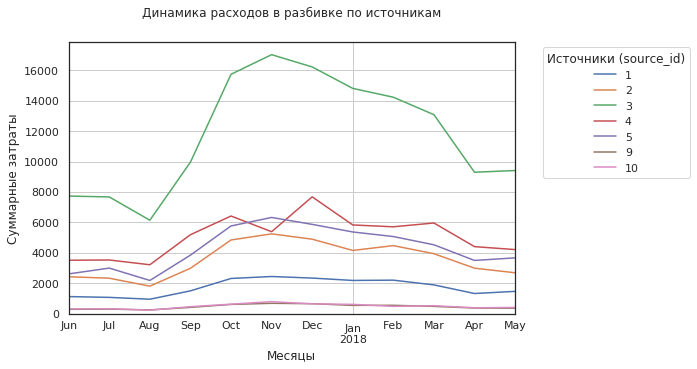

In [87]:
costs_source_month = costs.groupby(['source_id', 'first_order_month'])['costs'].sum().reset_index()

costs_source_month_pivot = costs_source_month.pivot_table(index=['first_order_month'], \
                                                          columns='source_id', values='costs', aggfunc='sum')

costs_source_month_pivot.plot(grid=True)
plt.title('Динамика расходов в разбивке по источникам')
plt.xlabel('Месяцы')
plt.ylabel('Суммарные затраты')
plt.ylim(bottom=0)
plt.legend(bbox_to_anchor=(1.05, 1), title='Источники (source_id)')
plt.show()

#### 3.  Сколько стоило привлечение одного покупателя из каждого источника (CAC)

**а) Средняя стоимость привлечения одного покупателя за весь период:**

In [88]:
costs_per_buyer_mean = costs['costs'].sum() / orders['uid'].nunique()
print('Общая стоимость привлечения одного покупателя за весь период: {} y.e.'.format(costs_per_buyer_mean.round(2)))

Общая стоимость привлечения одного покупателя за весь период: 9.01 y.e.


**б) Стоимость привлечения одного покупателя по источникам:**

Количество покупателей по источникам привлечения:

In [89]:
# воспользуемся написанной ранее функцией
cohort_sizes_source = cohort_size_calc('source_id')
cohort_sizes_source

,source_id,cohort_size
0,1,2899
1,2,3506
2,3,10473
3,4,10296
4,5,6931
5,7,1
6,9,1088
7,10,1329


Присоединяем затраты по источникам:

In [90]:
cac_source = cohort_sizes_source.merge(costs_source, on='source_id')
cac_source

,source_id,cohort_size,costs
0,1,2899,20833.27
1,2,3506,42806.04
2,3,10473,141321.63
3,4,10296,61073.60
4,5,6931,51757.10
5,9,1088,5517.49
6,10,1329,5822.49


,source_id,cohort_size,costs,cac
2,3,10473,141321.63,13.49
1,2,3506,42806.04,12.21
4,5,6931,51757.10,7.47
0,1,2899,20833.27,7.19
3,4,10296,61073.60,5.93
5,9,1088,5517.49,5.07
6,10,1329,5822.49,4.38


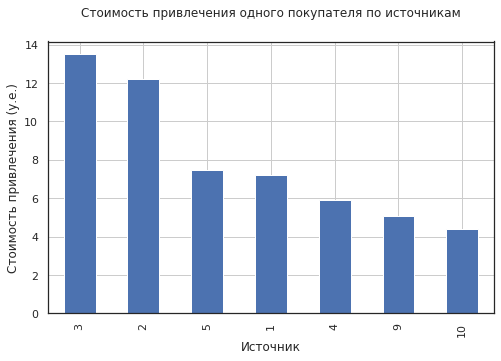

In [91]:
cac_source['cac'] = (cac_source['costs'] / cac_source['cohort_size']).round(2)
cac_source_sorted = cac_source.sort_values(by='cac', ascending=False)

display(cac_source_sorted)

cac_source_sorted.plot(kind='bar', x='source_id', y='cac', grid=True, legend=False)

plt.title('Стоимость привлечения одного покупателя по источникам')
plt.xlabel('Источник')
plt.ylabel('Стоимость привлечения (y.e.)')
plt.show()

**в) Динамика CAC в разрезе по источникам:**

Воспользуемся ранее созданной таблицей с расходами по источникам и месяцам:

In [92]:
costs_source_month.head(10)

,source_id,first_order_month,costs
0,1,2017-06-01,1125.61
1,1,2017-07-01,1072.88
2,1,2017-08-01,951.81
3,1,2017-09-01,1502.01
4,1,2017-10-01,2315.75
5,1,2017-11-01,2445.16
6,1,2017-12-01,2341.20
7,1,2018-01-01,2186.18
8,1,2018-02-01,2204.48
9,1,2018-03-01,1893.09


Посчитаем по источникам количество привлеченных в каждый месяц уникальных покупателей:

In [93]:
buyers_sources = payers_orders_attr.groupby(['source_id', 'first_visit_month']).agg({'uid':'nunique'})
buyers_sources

uid
source_id first_visit_month     
1         2017-06-01         240
          2017-07-01         184
          2017-08-01         126
          2017-09-01         248
          2017-10-01         350
...                          ...
10        2018-01-01         103
          2018-02-01         113
          2018-03-01         166
          2018-04-01          98
          2018-05-01         101

[85 rows x 1 columns]

Соединим расходы и количество привлеченных покупателей:

In [94]:
costs_by_date = buyers_sources.merge(costs_source_month, left_on=['source_id','first_visit_month'], \
                                     right_on=['source_id','first_order_month'])
costs_by_date

,source_id,uid,first_order_month,costs
0,1,240,2017-06-01,1125.61
1,1,184,2017-07-01,1072.88
2,1,126,2017-08-01,951.81
3,1,248,2017-09-01,1502.01
4,1,350,2017-10-01,2315.75
...,...,...,...,...
79,10,103,2018-01-01,614.35
80,10,113,2018-02-01,480.88
81,10,166,2018-03-01,526.41
82,10,98,2018-04-01,388.25


Считаем CAC:

In [95]:
costs_by_date['cac'] = costs_by_date['costs'] / costs_by_date['uid']
costs_by_date

,source_id,uid,first_order_month,costs,cac
0,1,240,2017-06-01,1125.61,4.69
1,1,184,2017-07-01,1072.88,5.83
2,1,126,2017-08-01,951.81,7.55
3,1,248,2017-09-01,1502.01,6.06
4,1,350,2017-10-01,2315.75,6.62
...,...,...,...,...,...
79,10,103,2018-01-01,614.35,5.96
80,10,113,2018-02-01,480.88,4.26
81,10,166,2018-03-01,526.41,3.17
82,10,98,2018-04-01,388.25,3.96


Строим график:

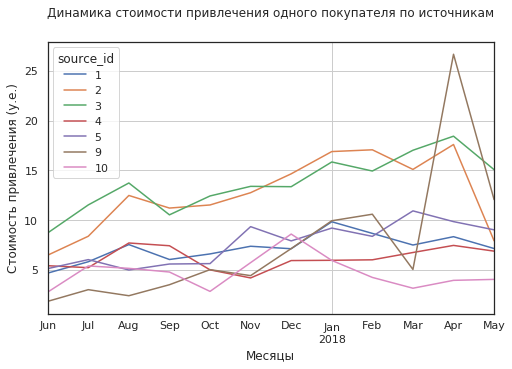

In [96]:
costs_by_date_pivot = costs_by_date.pivot_table(index='first_order_month', columns='source_id',\
                                                values='cac', aggfunc='first')
costs_by_date_pivot.plot(grid=True)
plt.title('Динамика стоимости привлечения одного покупателя по источникам')
plt.xlabel('Месяцы')
plt.ylabel('Стоимость привлечения (y.e.)')
plt.show()

#### 4. Насколько окупились расходы (ROI)

**а) Общий ROI = суммарные доходы / суммарные расходы:**

In [97]:
roi_total = orders['revenue'].sum() / costs['costs'].sum() * 100
print('Общий ROI по всем источникам за весь период: {}%'.format(roi_total.round(2)))

Общий ROI по всем источникам за весь период: 76.58%


**б) Возврат инвестиций в разрезе по источникам:**

Доход по источникам:

In [98]:
revenue_per_sources = payers_orders_attr.groupby(['source_id'])['revenue'].sum().reset_index()
revenue_per_sources

,source_id,revenue
0,1,31090.55
1,2,46923.61
2,3,54511.24
3,4,56696.83
4,5,52624.02
5,7,1.22
6,9,5759.40
7,10,4450.33


Соединяем данные о расходах и доходах по источникам, считаем ROI:

In [99]:
roi_per_sources = pd.merge(costs_source, revenue_per_sources, on='source_id')
roi_per_sources['roi'] = roi_per_sources['revenue'] / roi_per_sources['costs'] * 100

roi_per_sources_sorted = roi_per_sources.sort_values(by='roi', ascending=False)
roi_per_sources_sorted

,source_id,costs,revenue,roi
0,1,20833.27,31090.55,149.24
1,2,42806.04,46923.61,109.62
5,9,5517.49,5759.40,104.38
4,5,51757.10,52624.02,101.67
3,4,61073.60,56696.83,92.83
6,10,5822.49,4450.33,76.43
2,3,141321.63,54511.24,38.57


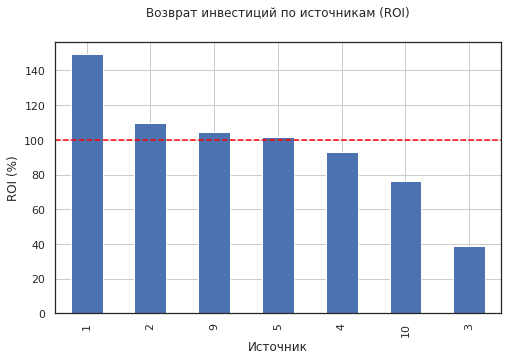

In [100]:
roi_per_sources_sorted.plot(kind='bar', x='source_id', y='roi', grid=True, legend=False)
    
plt.title('Возврат инвестиций по источникам (ROI)')
plt.xlabel('Источник')
plt.ylabel('ROI (%)')
plt.axhline(y = 100, color='red', linestyle='--')
plt.show()

### Промежуточные выводы

При анализе маркетинговой стороны продукта мы посчитали метрики:

- Общие затраты:
  - Всего потратили 329131.62 y.e.,
  - Больше всего тратили в октябре-декабре 2017; меньше всего - в августе 2017,
  - Больше всего вкладывались в 3 источник (141321.63), остальные с большим отрывом,
  - Меньше всего вкладывались в источники 9 и 10 (меньше 6000),
  - Динамика расходов по источникам  в целом схожа с общей динамикой. Из особенностей: по 10 источнику стабильно маленькие расходы, по 4 источнику – в ноябре провал, в декабре – всплеск затрат;

- Стоимость привлечения:
  - Общая стоимость привлечения одного покупателя за весь период: 9.01 y.e.,
  - Дороже всего обошлись покупатели из 3 (13.5) и 2 (12.2) источников. Дешевле всего - 9 (5) и 10 (4.4),
  - В апреле 2018 был взлет стоимости привлечения из 9 источника;

- Общий ROI по всем источникам за весь период: 76.58%; 

- Когортынй анализ LTV и ROI:
  - Выше всего LTV у когорты, пришедшей в сентябре 2017: на восьмой месяц = 13.44 y.e, на втором месте – июнь 2017 (на 11 месяц = 11.88). Окупились только эти когорты,
  - Меньше всего LTV у когорты, пришедшей в феврале 2018 (на 3 месяц жизни 4.59),
  - По ROI хуже всего когорты, пришедшие в январе, феврале и апреле 2018 (окупаемость около 50%),
  - LTV выше всего у пользователей, пришедших из источников 2 (13.38 y.e) и 1 (10.72),
  - LTV ниже всего у источников 3, 9, 4 (чуть больше 5),
  - Окупились источники 1, 2, 5, 9,
  - Быстрее всего окупился 1-ый источник – в конце 1-го месяца жизни, итоговая окупаемость 149.2%,
  - Хуже всего окупаемость у источника 3 (38.6%), с первого месяца окупаемость почти не увеличилась,
  - Устройства: с десктопа платят лучше (LTV 7.2 y.e. против 5.6 с мобильных устройств), окупаемость тоже выше (80.3% против 61.8%).

<div align='right'><a href='#content'>↑ В начало проекта ↑</a></div>

---

## <a id='results'>Шаг 3. Выводы и рекомендации</a>

**Задание**: порекомендуйте маркетологам, куда и сколько им стоит вкладывать денег? Какие источники/платформы вы бы порекомендовали? Объясните свой выбор: на какие метрики вы ориентируетесь? Почему? Какие выводы вы сделали, узнав значение метрик?

1. Рекомендую вкладываться в продвижение на desktop, так как у пользователей, пришедших в продукт с ноутбуков / компьютеров лучше показатели:
   - В два раза больше аудитория,
   - Пользователи приносят больше денег за время жизни в продукте (LTV 7.23 y.e. против 5.57 y.e. на мобильных устройствах),
   - Окупаемость тоже выше (ROI 80.3% против 61.8%).

2. По источникам рекомендую вкладываться в источники 1, 2, 4, 5 и 9:
   - Вложения в источники 1, 2, 5 и 9 полностью окупились,
   - 1 и 2 — самая высокая окупаемость (1 = 149.2%, 2 = 109.6% — и это не смотря на то, что покупатели из второго источника обходятся дорого, источник 2 на втором месте по стоимости привлечения),
   - Так же пользователи, пришедшие из источников 1 и 2 больше покупают, у них выше средний чек и LTV,
   - 9 — при небольших вложениях стоимость привлечения около 5 y.e., а окупаемость больше 100%,
   - Из источников 5 и 4 приходят качественные пользователи, у которых хорошие значения продуктовых метрик (см. расчет ниже). Источник 4 не окупился, но значение ROI кажется перспективным (92.8%),
   - Из 3 источника тоже приходят качественные покупатели (этот источник лидирует в хороших когортах), но у этого источника низкий ROI (38.6%).


3. Важно обратить внимание и учесть при планировании маркетинговых активностей:
   - В январе пользовательская активность и средний чек снижаются,
   - После новогодних праздников пользователи активизируются, активность достигает пика к декабрю (видимо, покупают билеты на мероприятия в качестве подарков). В декабре 2017 был пик посещаемости (возможно, это связано с большими вложениями в маркетинг),
   - К концу анализируемого периода средний чек устойчиво снижается.

Дополнительно хочется отметить, что самые высокие продуктовые показатели – у когорт, пришедших в продукт в июне и сентябре 2017:
- У когорты июня 2017 – самый высокий retention и среднее количество покупок в месяц,
- Выше всего LTV у когорты, пришедшей в сентябре 2017: на восьмой месяц = 13.44 y.e., на втором месте – июнь 2017 (на 11 месяц = 11.88 y.e.).

Скорее всего, это связано с тем, что в эти месяцы удалось привлечь качественных пользователей, которым подошел продукт. Поэтому важно посмотреть источники, из которых приходили пользователи в эти периоды:

In [101]:
# смотрим источники пользователей, которые пришли в хорошие по продуктовым метрикам когорты (июнь и сентябрь 2019)
(payers_orders_attr
 .query('first_order_month == "2017-06-01" | first_order_month == "2017-09-01"')
 .groupby(['first_order_month', 'source_id']).agg({'uid':'nunique'})
 .sort_values(by=['first_order_month', 'uid'], ascending=False))

uid
first_order_month source_id     
2017-09-01        3          781
                  4          590
                  5          589
                  1          227
                  2          221
                  9           87
                  10          86
2017-06-01        3          638
                  4          413
                  5          384
                  2          235
                  1          190
                  10          95
                  9           68

Соответствующие рекомендации по источникам описаны выше.

<div align='right'><a href='#content'>↑ В начало проекта ↑</a></div>